## Code to identify promoters of mating genes in different species.
> written by Sri Srikant, 20200415 for use with Harvard Odyssey 2.0 in py2 for job submission to the SLURM scheduler

The goal of this notebook is to develop methods to predict fungal lipidated (a-like) pheromones in yeast species from their genome sequence. The code is written with the intention of using the 332 yeast genomes published in Shen XX et al, Cell (2018). This notebook is the corollory of the primary code-base in {pheromoneFinder.py} that is also written for running on Odyssey 2.0 SLURM scheduler. This code-base is written to identify the promoters of mating genes in various yeasts (by identifying orthologs to mating genes in S. cerevisiae) and extract the conserved motifs for these promoters which are the presumed motifs of transcription factors that control mating. Finally, the code will look for the presence of these motifs upstream of the candidates identified by {pheromoneFinder.py}. The presence of these motifs offers a scoring strategy to rank-order candidates for testing to find true pheromones.

In [65]:
##Importing all the relevant libraries.
import sys
import os
from os import listdir
from os.path import isfile, join
import subprocess
import shlex

import traceback
import re
import collections

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio import pairwise2
from collections import defaultdict
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast.Applications import NcbitblastnCommandline
from Bio.Blast import NCBIXML
import xml.etree.ElementTree as ET

#import dendropy
import numpy as np
import seaborn as sns
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt

import csv
import math
import operator
import itertools
from operator import attrgetter
from pprint import pprint

data_dir = "../"

In [66]:
##These are Classes and Functions
###Not using this for now.
class Pipeline(object):
    def __init__(self, command):
        self.command = command
        self.command_list = self.command.split('|')
        self.output = None
        self.errors = None
        self.status = None
        self.result = None

    def run(self):
        process_list = list()
        previous_process = None
        for command in self.command_list:
            args = shlex.split(command)
            if previous_process is None:
                process = subprocess.Popen(args, stdout=subprocess.PIPE)
            else:
                process = subprocess.Popen(args,
                                           stdin=previous_process.stdout,
                                           stdout=subprocess.PIPE)
            process_list.append(process)
            previous_process = process
        last_process = process_list[-1]
        self.output, self.errors = last_process.communicate()
        self.status = last_process.returncode
        self.result = (0 == self.status)
        return self.result

class FASTAStructureMinimal():
    def __init__(self, id, seq):
        self.id = id
        self.seq = seq
        
###Functions to modify pandas dataframe
def insert_species_name(row):
    return row['sequence name'].split("|/|")[0]

####Functions to modify the pandas dataframe 'candidate_promoter_stats_frame'
def fimostats_insert_species_name(row):
    return row['PheromoneCandidateName'].split("|/|")[0]

def fimostats_insert_chr_id(row):
    return row['PheromoneCandidateName'].split("|/|")[1].split("||")[0]

def fimostats_insert_cys_pos(row):
    return int(row['PheromoneCandidateName'].split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-2])

def fimostats_insert_stop_pos(row):
    return int(row['PheromoneCandidateName'].split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-1].split("]")[0])
        
##Functions from Peter Culviner (https://www.github.com/peterculviner), wrappers to use meme locally. I have installed meme-5.1.1 on WSL Ubuntu 18.04 with python 2.7.
def parsememexml(xml_path, library_order = 'ATGC'):
    # populate a list for scores and frequencies from meme output
    motif_details = []
    motif_scores = []
    motif_frequencies = []
    motif_regex = []
    counts = []
    # pull motifs from the xml file
    open_xml = ET.parse(xml_path)
    found_motifs = open_xml.getroot().find('motifs')
    for motif in found_motifs:
        #Modified by Sri, Details of the motif for use in comparissons.
        motif_name = motif.attrib['name']
        motif_width = motif.attrib['width']
        motif_evalue = motif.attrib['e_value']
        #motif_pvalue = motif.attrib['p_value'] #Not present in meme-4.9.0
        # populate empty arrays to fill, set to np.nan
        scores = np.zeros((int(motif.attrib['width']),len(library_order))) + np.nan
        frequencies = np.zeros((int(motif.attrib['width']),len(library_order))) + np.nan
        # add counts of instances used to build the motif
        counts.append(int(motif.attrib['sites']))
        # iterate across scores
        for position_i,position_data in enumerate(motif.find('scores').find('alphabet_matrix')):
            # iterate across letters for each position
            for letter_data in position_data:
                letter_i = library_order.find(letter_data.attrib['letter_id']) # determine letter_i based on library_order kwarg
                scores[position_i,letter_i] = float(letter_data.text)
        # iterate across frequencies
        for position_i,position_data in enumerate(motif.find('probabilities').find('alphabet_matrix')):
            # iterate across letters for each position
            for letter_data in position_data:
                letter_i = library_order.find(letter_data.attrib['letter_id']) # determine letter_i based on library_order kwarg
                frequencies[position_i,letter_i] = float(letter_data.text)
        motif_details.append([motif_name, motif_width, motif_evalue]) #Removed motif_pvalue
        motif_scores.append(scores)
        motif_frequencies.append(frequencies)
        motif_regex.append(motif.find('regular_expression').text.replace('\n',''))
    # pull letter frequences from xml file
    bg_frequencies = np.zeros(4)
    bg_letters = open_xml.getroot().find('training_set').find('letter_frequencies').find('alphabet_array')
    for letter_data in bg_letters:
        letter_i = library_order.find(letter_data.attrib['letter_id'])
        bg_frequencies[letter_i] = float(letter_data.text)
    # output data
    return motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies

##Parameters of MEME ['-dna','-nostatus', '-time', '18000', '-mod', 'anr', '-nmotifs', '3', '-minw', '6', '-maxw', '15', '-objfun', 'classic', '-revcomp', '-markov_order', '0']
##For WSL Ubuntu 18.04 ['-dna','-nostatus', '-time', '18000', '-mod', 'zoops', '-nmotifs', '3', '-minw', '5', '-maxw', '10', '-objfun', 'classic', '-revcomp', '-markov_order', '0'] meme-5.1.1
##For Odyssey 2.0 ['-dna','-nostatus', '-time', '18000', '-mod', 'zoops', '-nmotifs', '3', '-minw', '5', '-maxw', '10'] meme-4.9.0
##[delete_outputs = True] will prevent bloating the directory.
def memewrapper(fasta_path,
                meme_path = '/home/ssrikant/local/meme/bin/meme',
                meme_args = ['-dna','-nostatus', '-time', '18000', '-mod', 'zoops', '-nmotifs', '3', '-minw', '5', '-maxw', '10', '-objfun', 'classic', '-revcomp', '-markov_order', '0'],
                delete_outputs = False):
    # run meme
    base_directory = '/'.join(fasta_path.split('/')[:-2])
    file_name = fasta_path.split("/")[-1].split(".")[0]
    ###Base output directory check
    if not(os.path.isdir(os.path.join(base_directory, 'meme_output'))):
        os.mkdir(os.path.join(base_directory, 'meme_output'))
    ###Categorical output directory check; 'species' OR 'phyloGroup', and making the lowest per-file output_directory
    if (file_name.find("phyloGroup") >= 0):
        if not(os.path.isdir(os.path.join(base_directory, 'meme_output', 'phyloGroup'))):
            os.mkdir(os.path.join(base_directory, 'meme_output', 'phyloGroup'))
        cat_output_dir = os.path.join(base_directory, 'meme_output', 'phyloGroup')
        if not(os.path.isdir(os.path.join(cat_output_dir, file_name))):
            os.mkdir(os.path.join(cat_output_dir, file_name))
    elif (file_name.find("phyloGroup") == -1):
        if not(os.path.isdir(os.path.join(base_directory, 'meme_output', 'species'))):
            os.mkdir(os.path.join(base_directory, 'meme_output', 'species'))
        cat_output_dir = os.path.join(base_directory, 'meme_output', 'species')
        if not(os.path.isdir(os.path.join(cat_output_dir, file_name))):
            os.mkdir(os.path.join(cat_output_dir, file_name))
    
    output_dir = os.path.join(cat_output_dir, file_name)
    meme_command = [meme_path, fasta_path, '-oc', output_dir] + meme_args
    meme_cmd = subprocess.Popen(meme_command, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    print(meme_cmd.communicate()[1].decode('utf-8'))
    # pull motifs out
    if (os.path.isfile(os.path.join(output_dir, 'meme.xml'))):
        motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies = parsememexml(os.path.join(output_dir, 'meme.xml'))
    else:
        print("MEME outputs for "+str(file_name)+" was missing. Skipping this output!")
        motif_details = []
        motif_scores = []
        motif_frequencies = []
        motif_regex = []
        counts = []
        bg_frequencies = []
    # delete meme output files
    if delete_outputs is True:
        os.removedirs(output_dir)
        #subprocess.Popen(['rm','-r',output_dir])
    return motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies

##FIMO command wrapper for use in python2.7 scripting.
##FIMO command on Odyssey from meme-4.9.0, local WSL from meme-5.1.1 (Documentation http://web.mit.edu/meme_v4.11.4/share/doc/fimo.html)
##Parameters of MEME []
def fimowrapper(candidate_fasta_file,
                meme_motif_file,
                fimo_args = []
                ):
    base_directory = "/".join(candidate_fasta_file.split("/")[:-2])
    #print(base_directory)
    ###Base output dir check
    if not(os.path.isdir(os.path.join(base_directory, "fimo_output"))):
        os.mkdir(os.path.join(base_directory, "fimo_output"))
    #print(meme_motif_file.split("/")[-2])
    
    ###Categorical output directory check; 'species' OR 'phyloGroup', and making the lowest per-file output_directory
    if (meme_motif_file.split("/")[-2].find("phyloGroup") >= 0):
        if not(os.path.isdir(os.path.join(base_directory, 'fimo_output', 'phyloGroup'))):
            os.mkdir(os.path.join(base_directory, 'fimo_output', 'phyloGroup'))
        cat_output_dir = os.path.join(base_directory, 'fimo_output', 'phyloGroup')
        if not(os.path.isdir(os.path.join(cat_output_dir, meme_motif_file.split("/")[-2]))):
            os.mkdir(os.path.join(cat_output_dir, meme_motif_file.split("/")[-2]))
    elif (meme_motif_file.split("/")[-2].find("phyloGroup") == -1):
        if not(os.path.isdir(os.path.join(base_directory, 'fimo_output', 'species'))):
            os.mkdir(os.path.join(base_directory, 'fimo_output', 'species'))
        cat_output_dir = os.path.join(base_directory, 'fimo_output', 'species')
        if not(os.path.isdir(os.path.join(cat_output_dir, meme_motif_file.split("/")[-2]))):
            os.mkdir(os.path.join(cat_output_dir, meme_motif_file.split("/")[-2]))
    
    output_dir = os.path.join(cat_output_dir, meme_motif_file.split("/")[-2])
    fimo_cmd_args = ['fimo', '-oc', output_dir, meme_motif_file, candidate_fasta_file] + fimo_args
    fimo_cmd = subprocess.Popen(fimo_cmd_args, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    return fimo_cmd.communicate()
    

In [67]:
##Defining directories to run code.
###When I make the functions to be used on Odyssey these have to be changed accordingly! Especially the genome_dir and the protein_dir are going to be made into static links.
###Remember to run the code block below before the "_Processed" folders show up.
genome_dir = os.path.join(data_dir, "seqfiles", "genomes_Processed")
protein_dir = os.path.join(data_dir, "seqfiles", "proteins_Processed")
hmm_dir = os.path.join(data_dir, "hmm")
figure_dir = os.path.join(data_dir, "figures")

#### Code to add file name (species_name) to the genome and proteome files
Function to modify IDs of each sequence in genomes and proteomes of fungi. Modifying <pheromoneFinder/seqIdProcess> to address the fact that pulling just IDs gives non-unique identifiers for the proteomes. The genomes are fine since the contigs number is part of each identifier though there seems to be more information in the raw files.

In [251]:
###Modifying the function in pheromoneFinder to incorporate more than just the identifier in proteome FASTA which seem to have redundancies.
####Input variables:
    ####fasta_folder: Folder containing the FASTA files of the genomes or proteomes.
    ####dictionary_file: A .csv file with details of the file names matched to the "species names" of the fungi we are working with.
fasta_folder = os.path.join(data_dir, "seqfiles", "genomes")
dictionary_file = os.path.join(data_dir, "seqfiles", "332taxa_index.txt")
#This is to add the filename to the ids of chromosomes so that the species name (as contained in the file name) will be included in the chromosome identifiers.
if not(os.path.isdir(fasta_folder)):
    print "Input provided is not a folder. Please use the folder containing all sequence files, genomes or proteins."
else:
    seqFileList = [f for f in listdir(fasta_folder) if (f.endswith(".fasta") or f.endswith(".fas") or f.endswith(".fa") or f.endswith(".max.pep"))]
    writeCount = 1
    
    ##This is to create the folder to store the processed genome files.
    if not(os.path.isdir(str(fasta_folder[:-1])+"_Processed")):
        os.mkdir(str(fasta_folder[:-1])+"_Processed")
        
    ##This is to make the fungal genome to species dictionary.
    with open(dictionary_file, mode='r') as infile:
        reader = csv.reader(infile)
        fungalDictionary = {rows[0].split("\t")[0]: rows[0].split("\t")[2] for rows in reader}
        
    for g in seqFileList:
        records = open(os.path.join(fasta_folder, g), "rU")
        sequences = list(SeqIO.parse(records, "fasta"))
        records.close()
        
        #print(sequences[0])
        #print(sequences[0].description.replace(" ", "_||_"))
        #sys.exit()
        
        if (g.find(".f") >= 0): 
            speciesName = g.split(".f")[0]
        elif (g.find(".max.pep") >= 0):
            speciesName = g.split(".max.pep")[0]
        
        writeIndex = os.path.join(fasta_folder[:-1]+"_Processed/", g)
        outputHandle = open(writeIndex,"wb")
        if (g.find(".f") >= 0):
            for sequence_record in sequences:
                outputHandle.write(">"+str(speciesName)+"|/|"+str(sequence_record.id)+"\n"+str(sequence_record.seq)+"\n")
        elif (g.find(".max.pep") >= 0):
            for sequence_record in sequences:
                outputHandle.write(">"+str(speciesName)+"|/|"+str(sequence_record.description.replace(" ", "_||_"))+"\n"+str(sequence_record.seq)+"\n")
        outputHandle.close()
        writeCount += 1
        
    #I think I'm almost done!
    print "Done writing ", str(writeCount-1), " genome OR protein files in the "+str(fasta_folder[:-1])+"_Processed folder. Good luck!"


Done writing  6  genome OR protein files in the ../seqfiles/genome_Processed folder. Good luck!


#### Code to build the HMM profiles for the protein alignments
Result of phmmer search for the pheromoneActivatedGenes and aSpecificGenes in the Saccharomycetales (taxid:4692). The dictionary file (Scer-matingGenes_phmmer_200412.csv) contains the data of what the genes-of-interest are in the table with columns (GeneName,FileName,Category,SGDName,Hits).

In [50]:
## Printing file list
fileList = [f for f in listdir(hmm_dir) if f.endswith("afa")]
print("List of files:")
print("\n".join(fileList))

List of files:
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.1.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.2.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.3.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.4.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.5.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.6.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.7.afa
2C115178-7C4A-11EA-9E2D-FFB753F04F9B.8.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.1.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.2.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.3.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.4.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.5.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.6.afa
6B2B6CCC-7C68-11EA-B2EB-C555E976C163.7.afa
STE6Sc_Sergey-allDBv2_Fungiv2p1_Saccharomycetales_muscle.afa


In [15]:
## Defining the dictionary file for mating genes.
hmm_dict_file = os.path.join(hmm_dir, "Scer-matingGenes_phmmer_200416.csv")
hmm_dict = pd.read_csv(hmm_dict_file)
hmm_dict.head()

,GeneName,FileName,Category,SGDName,Hits
0,FIG1,2C115178-7C4A-11EA-9E2D-FFB753F04F9B.1,pheromoneActivatedGenes,YBR040W,65
1,PRM1,2C115178-7C4A-11EA-9E2D-FFB753F04F9B.2,pheromoneActivatedGenes,YNL279W,72
2,KAR4,2C115178-7C4A-11EA-9E2D-FFB753F04F9B.3,pheromoneActivatedGenes,YCL055W,72
3,KAR5,2C115178-7C4A-11EA-9E2D-FFB753F04F9B.4,pheromoneActivatedGenes,YMR065W,63
4,SST2,2C115178-7C4A-11EA-9E2D-FFB753F04F9B.5,pheromoneActivatedGenes,YLR452C,71


In [16]:
print(hmm_dict[hmm_dict['GeneName'] == 'FIG1']['FileName'].values+".afa")

['2C115178-7C4A-11EA-9E2D-FFB753F04F9B.1.afa']


In [52]:
##Looping to run hmmbuild on all the results listed in the dictionary file.
for index, record in hmm_dict.iterrows():
    input_file = os.path.join(hmm_dir, str(record['FileName'])+".afa")
    #print(input_file)
    output_file = os.path.join(hmm_dir, str(record['GeneName'])+"_"+str(record['FileName'])+".hmm")
    log_file = os.path.join(hmm_dir, str(record['GeneName'])+"_"+str(record['FileName'])+".log")
    
    hmmbuild_cmd = subprocess.call(["hmmbuild", "--amino", "-n", str(record['GeneName']), "-o", log_file, output_file, input_file])
print("Check "+hmm_dir+" for HMM profiles built by hmmbuild for the "+str(len(hmm_dict))+" gene alignments!\n")

Check ../hmm/ for HMM profiles built by hmmbuild for the 15 gene alignments!



In [19]:
##Running hmmsearch against the protein files of the various species files.
proteinFileList = [f for f in listdir(protein_dir) if f.endswith(".max.pep")]

for species_prot in proteinFileList:
    for index, record in hmm_dict.iterrows():
        input_prot_database = os.path.join(protein_dir, species_prot)
        hmm_file = os.path.join(hmm_dir, str(record['GeneName'])+"_"+str(record['FileName'])+".hmm")
        
        if not(os.path.isdir(os.path.join(data_dir, "hmmsearch_raw"))):
            os.mkdir(os.path.join(data_dir, "hmmsearch_raw"))
        hmmsearch_output_file = os.path.join(data_dir, "hmmsearch_raw", str(record['GeneName'])+"_0_"+species_prot.split(".max.pep")[0]+"_hmmsearch.out")
        hmmsearch_output_tblout = os.path.join(data_dir, "hmmsearch_raw", str(record['GeneName'])+"_0_"+species_prot.split(".max.pep")[0]+"_hmmsearch.tbl")
        
        hmmsearch_cmd = subprocess.call(["hmmsearch", "-o", hmmsearch_output_file, "--tblout", hmmsearch_output_tblout, hmm_file, input_prot_database])

In [20]:
##Pulling top-hits of hmmsearch for each hmmprofile and combining the hits by genome.
###First need to index all the protein collections
for species_prot in proteinFileList:
    eslsfetch_index_cmd = subprocess.call(["esl-sfetch", "--index", os.path.join(protein_dir, species_prot)])
    
    if not(os.path.isdir(os.path.join(data_dir, "hmmsearch_best"))):
        os.mkdir(os.path.join(data_dir, "hmmsearch_best"))
    output_fasta_file = os.path.join(data_dir, species_prot.split(".max.pep")[0]+"_hmmsearch.fasta")
    input_prot_database = os.path.join(protein_dir, species_prot)
    print("Working on finding homologous mating genes of "+species_prot.split(".max.pep")[0]+".\n")
    
    homolog_protein_collection = []
    
    for index, record in hmm_dict.iterrows():
        hmmsearch_output_tblout = os.path.join(data_dir, "hmmsearch_raw", str(record['GeneName'])+"_0_"+species_prot.split(".max.pep")[0]+"_hmmsearch.tbl")
        temp_output_file = os.path.join(data_dir, "hmmsearch_best", "temp_0_"+species_prot.split(".max.pep")[0]+".fasta")
        #temp = "grep -v \"^#\" "+hmmsearch_output_tblout+" | awk '{print $1}' | esl-sfetch"+" -f "+input_prot_database+" - > "+temp_output_file
        #eslsfetch_cmd = subprocess.call([temp])
                
        command = '|'.join([
            "grep -v \"^#\" "+hmmsearch_output_tblout,
            "awk '{print $1}'",
            "esl-sfetch -f "+input_prot_database+" - > "+temp_output_file
        ])
        #print command
        ##This works exactly as needed but python strongly discourages using shell=True since it is not secure. I am going to go ahead with this temporarily.
        eslsfetch_cmd = subprocess.call([command], shell=True)
        #pipeline = Pipeline(command)
        #if not pipeline.run():
        #    print "ERROR: Pipeline failed"
        #else:
        #    print pipeline.output
        #sys.exit()
        
        ##The next step is to open the results file and append the top hit to a class for all mating homologous genes into a single file. 
        ##I can then delete the temp file of the output file.
        input_temp_seq_file = temp_output_file
        file_handle = open(input_temp_seq_file, "r")
        temp_candidates = list(SeqIO.parse(file_handle, "fasta"))
        file_handle.close()
        
        #print(str(record['GeneName'])+"|/|"+temp_candidates[0].id+"\n"+temp_candidates[0].seq)
        if not temp_candidates:
            print("No homolog found for "+str(record['GeneName'])+" in "+species_prot.split(".max.pep")[0]+". Skipping!\n")
        else:
            homolog_protein_collection.append(FASTAStructure(str(record['GeneName'])+"|/|"+temp_candidates[0].id, temp_candidates[0].seq))
            print("Homolog found for "+str(record['GeneName'])+" in "+species_prot.split(".max.pep")[0]+". "+homolog_protein_collection[-1].id+" has been saved!")
        os.remove(temp_output_file)
    
    print("There are "+str(len(homolog_protein_collection))+" mating gene homologs identified in "+species_prot.split(".max.pep")[0]+". Good luck!")
    for homolog in homolog_protein_collection:
        print("\t"+homolog.id.split("|/|")[0])
        
    homolog_byspecies_output_file = os.path.join(data_dir, "hmmsearch_best", "homologs_0_"+species_prot.split(".max.pep")[0]+".fasta")
    output_file_handle = open(homolog_byspecies_output_file, "w")
    for homolog in homolog_protein_collection:
        output_file_handle.write(">"+str(homolog.id)+"\n"+str(homolog.seq)+"\n")
    output_file_handle.close()
    

Working on finding homologous mating genes of alloascoidea_hylecoeti.

Homolog found for FIG1 in alloascoidea_hylecoeti. FIG1|/|alloascoidea_hylecoeti|/|-processed-gene-8.8-mRNA-1_1_||_gene=augustus_masked-gi|1002318379|dbj|BCKZ01000004.1|-processed-gene-8.8_||_CDS=1-828 has been saved!
Homolog found for PRM1 in alloascoidea_hylecoeti. PRM1|/|alloascoidea_hylecoeti|/|-processed-gene-10.23-mRNA-1_1_||_gene=augustus_masked-gi|1002318380|dbj|BCKZ01000003.1|-processed-gene-10.23_||_CDS=1-2499 has been saved!
Homolog found for KAR4 in alloascoidea_hylecoeti. KAR4|/|alloascoidea_hylecoeti|/|-processed-gene-11.61-mRNA-1_1_||_gene=augustus_masked-gi|1002318381|dbj|BCKZ01000002.1|-processed-gene-11.61_||_CDS=1-942 has been saved!
Homolog found for KAR5 in alloascoidea_hylecoeti. KAR5|/|alloascoidea_hylecoeti|/|-processed-gene-11.33-mRNA-1_1_||_gene=snap_masked-gi|1002318381|dbj|BCKZ01000002.1|-processed-gene-11.33_||_CDS=1-1932 has been saved!
Homolog found for SST2 in alloascoidea_hylecoeti. S

In [22]:
###Need to write a small piece of code to use makeblastdb to generate the blastdb files that I can use for the blastN.
###Remember to define the genome directory as the genome_blastdb_dir. Should I make separate folders for the makeblastdb output and for the base genome files? I think so.
genome_blast_dir = os.path.join(data_dir, "seqfiles/blastdb_genome")
genome_file_list = [f for f in os.listdir(genome_blast_dir) if (f.endswith(".fasta") or f.endswith(".fas") or f.endswith(".fa"))]
for species_genome in genome_file_list:
    blastdb_input_file = os.path.join(genome_blast_dir, species_genome)
    blastdb_input_file_type = "fasta"
    blastdb_dbtype = "nucl"
    blastdb_genome_title = species_genome.split(".f")[0]
    
    makeblastdb_cmd = subprocess.Popen(["makeblastdb", "-dbtype", blastdb_dbtype, "-input_type", blastdb_input_file_type, "-title", blastdb_genome_title, "-in", blastdb_input_file], 
                                      stdout=subprocess.PIPE)
    stdout = makeblastdb_cmd.communicate()
    
    print("Done make the blast database with the genome file of "+species_genome.split(".f")[0]+", the blastdb folder is in "+genome_blast_dir)    

Done make the blast database with the genome file of alloascoidea_hylecoeti, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of ambrosiozyma_kashinagacola, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of ambrosiozyma_monospora, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of candida_albicans, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of saccharomyces_cerevisiae, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of yHAB155_kazachstania_spencerorum_160519, the blastdb folder is in ../seqfiles/blastdb_genome
Done make the blast database with the genome file of yarrowia_lipolytica, the blastdb folder is in ../seqfiles/blastdb_genome


In [151]:
###Using top hits from the hmmsearch from each species proteome (saved in a single file) and identifying their positions in the genomes (stored in the genome folder) using tBLASTN.
##From these positions pull out the "promoter" of each homolog. Defined identical to what I used before with <pheromoneFinder/promoterExtract> as a 1000bp upstream from the start.
###I am also going to use some of the code from <pheromoneFinder/scorePheromone>
###Remember to modify the code such that "species_genome" variable is ingested from the main section of code and called into the function.
###The other variables that are pulled/defined are the "data_dir" (which should be ./)
###The "blastdb_genome_dir" has to be hard defined as a copy of the genome folder in my server subfolder on which I run the 
genome_file_list = [f for f in os.listdir(genome_dir) if (f.endswith(".fasta") or f.endswith(".fas") or f.endswith(".fa"))]
blastdb_genome_dir = os.path.join(data_dir, "seqfiles/blastdb_genome")
for species_genome in genome_file_list:
    print("Finding the tBLASTN hits of hmmsearch hits of the homologous mating proteins against the corresponding genomes.\n")
    tblastn_query_file = os.path.join(data_dir, "hmmsearch_best", "homologs_0_"+species_genome.split(".f")[0]+".fasta")    
    
    if not(os.path.isdir(os.path.join(data_dir, "tblastn"))):
        os.mkdir(os.path.join(data_dir, "tblastn"))
    tblastn_output_file = os.path.join(data_dir, "tblastn", species_genome.split(".")[0]+"_tblastn.tbl")
    
    tblastn_db = os.path.join(blastdb_genome_dir, species_genome)
    #print outputXML
    #exit()
    ##Output format 5 corresponds to an xml, while format 6 is tabular output (without comments)
    tblastn_cmd = NcbitblastnCommandline(query=tblastn_query_file, db=tblastn_db, outfmt=6, out=tblastn_output_file)
    stdOut, stdErr = tblastn_cmd()

    ##I am going to parse the output XML from the tBLASTN of the putative pheromones and using the the e-value of the top result.
    ###tblastn_results_raw = NCBIXML.parse(read_tblastn_handle)
    ###tblastn_results = list(tblastn_results_raw)
    ##The tabular output of tBLASTN has the results in the following columns [qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore]
    try:
        #read_tblastn_handle = open(tblastn_output_file)
        tblastn_column_names = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
        tblastn_results = pd.read_csv(tblastn_output_file, sep="\t", names=tblastn_column_names)
        #read_tblastn_handle.close()
    except:
        print "The tabular output of tBLASTN is missing!"
        sys.exit()
        
    ####Importing the genome sequence and storing it to a dictionary.
    genome_dictionary = {}
    genome_fasta_handle = open(os.path.join(genome_dir, species_genome), "r")
    genome_fasta_read = list(SeqIO.parse(genome_fasta_handle, "fasta"))
    genome_fasta_handle.close()
    
    for chromosome in genome_fasta_read:
        genome_dictionary.update({chromosome.id: chromosome.seq})
    
    #print(tblastn_results['qseqid'].unique())
    homolog_promoters_fasta = []
    for query_seqid in tblastn_results['qseqid'].unique():
        temp_result_frame = pd.DataFrame()
        temp_result_frame = tblastn_results[tblastn_results['qseqid'] == query_seqid].sort_values(by=['evalue'], ascending=True).copy()
        #print(temp_result_frame)
        
        if (temp_result_frame['length'].iloc[0] == temp_result_frame['length'].max()):
            if (temp_result_frame['sstart'].iloc[0] < temp_result_frame['send'].iloc[0]):
                orf_start = temp_result_frame['sstart'].iloc[0] - 3*(temp_result_frame['qstart'].iloc[0] - 1)
                #print(orf_start)
                if (orf_start <= 1000):
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][0:orf_start-1]
                else:
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start-1001:orf_start-1]
            elif (temp_result_frame['sstart'].iloc[0] > temp_result_frame['send'].iloc[0]):
                orf_start = temp_result_frame['sstart'].iloc[0] + 3*(temp_result_frame['qstart'].iloc[0] - 1)
                if (orf_start >= (len(genome_dictionary[temp_result_frame['sseqid'].iloc[0]]) - 1000)):
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start:].reverse_complement()
                else:
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start:orf_start+1000].reverse_complement()
        else:
            print("The alignment with the lowest evalue is saved, but the longest match is:\n"
                  +str(temp_result_frame[temp_result_frame['length'] == temp_result_frame['length'].max()]['sseqid'].values)
                  +"\t"+str(temp_result_frame[temp_result_frame['length'] == temp_result_frame['length'].max()]['sstart'].values)
                  +"-"+str(temp_result_frame[temp_result_frame['length'] == temp_result_frame['length'].max()]['send'].values))
            if (temp_result_frame['sstart'].iloc[0] < temp_result_frame['send'].iloc[0]):
                orf_start = temp_result_frame['sstart'].iloc[0] - 3*(temp_result_frame['qstart'].iloc[0] - 1)
                if (orf_start <= 1000):
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][0:orf_start-1]
                else:
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start-1001:orf_start-1]
            elif (temp_result_frame['sstart'].iloc[0] > temp_result_frame['send'].iloc[0]):
                orf_start = temp_result_frame['sstart'].iloc[0] + 3*(temp_result_frame['qstart'].iloc[0] - 1)
                if (orf_start >= (len(genome_dictionary[temp_result_frame['sseqid'].iloc[0]]) - 1000)):
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start:].reverse_complement()
                else:
                    promoter_seq = genome_dictionary[temp_result_frame['sseqid'].iloc[0]][orf_start:orf_start+1000].reverse_complement()
        
        if (len(promoter_seq) > 50):
            homolog_promoters_fasta.append(FASTAStructureMinimal(temp_result_frame['qseqid'].iloc[0].replace('"', ''), promoter_seq))
            print("Saving the 1000bp promoter region:\n"+homolog_promoters_fasta[-1].id+"\n"+homolog_promoters_fasta[-1].seq+"\n")
        elif (len(promoter_seq) <= 50):
            print("Skipping the promoter region:\n"+temp_result_frame['qseqid'].iloc[0].replace('"', '')+"\n"+promoter_seq+"\n")
        
    if not(os.path.isdir(os.path.join(data_dir, "promoters"))):
        os.mkdir(os.path.join(data_dir, "promoters"))
    promoter_output_file = os.path.join(os.path.join(data_dir, "promoters", "promoters_0_"+species_genome.split(".f")[0]+".fasta"))
    output_file_handle = open(promoter_output_file, "w")
    for homolog in homolog_promoters_fasta:
        output_file_handle.write(">"+str(homolog.id)+"\n"+str(homolog.seq)+"\n")
    output_file_handle.close()
    
    print("Done printing promoters of "+str(len(homolog_promoters_fasta))+" mating homologous genes in "+species_genome.split(".f")[0]+".\n")

Finding the tBLASTN hits of hmmsearch hits of the homologous mating proteins against the corresponding genomes.

Saving the 1000bp promoter region:
FIG1|/|alloascoidea_hylecoeti|/|-processed-gene-8.8-mRNA-1_1_||_gene=augustus_masked-gi|1002318379|dbj|BCKZ01000004.1|-processed-gene-8.8_||_CDS=1-828
TTGCAGGTGGTAAATGGTCAGATCATATAGTTAAAAGACAACAACGTAAAAACAATGGAGTTTTGATTCCTGAAGAAAGAATTGCTGAGAATTCATTTGCTGCTTCAATTATTTATCCACTTTCTATTTTGATTTTTTCATGGCCTTTACATTATGGAAAACATTGGGTTATTCCTTTGGTTGGGACATTTCTTTTTGGATTTGGATCAATGCTTGTATTCGGAACCACGGTTACTTATCTTATTGATGCTTTACCTGGAAGAGGTGCTAGTGGTGTTGCTGTGAATAATCTCTTTAGATTAACATTAGGTGCAGTGGCAACATTCGCTAATCATTCGGAGATAGAATCTATGGGAGTTGGCTGGACAGGAACAATGTGCTGTCTTCTTGGGCTTATATCTTCCTTGTGTTTGCTTTCTATTAAGATTTTTGGACCAAAATGGAGGAAATCTGTAAACTTGGAGAGGCTATATTCTTAAAGTGTATAACCTTATAGCTAGAGACAATTTGAATTATGGTTGGCCTTGTATTGAGATAAAAATATTGTTATATCATCGTTTTATCATTGCTATTTCATTTTCCAATTGTTTTACTTATAATCTTATACACATAATGTTTTTGTTAAATCAGTTTTATATGGACGTTTCATGGTACTATAAATGCAAACGTTATTATTAATATTATACATAATTACTGTTTTG

In [116]:
##Function to read through the fasta files of best hmmsearch hits in a folder and output the list of homologs identified accross species or phylogenetic groups.
##The input values into this function are:
    ###hmmsearch_dir = This is the folder that contains the FASTA files of the promoters of different species or different phyloGroups
    ###hmm_dict_file = This is the dictionary file of the mating genes whoose homologs were found in various fungi. The genes belong to two classes: 'pheromoneActivatedGenes' & 'aSpecificGenes'
hmm_dict_file = os.path.join(hmm_dir, "Scer-matingGenes_phmmer_200416.csv")
hmmsearch_dir = os.path.join(data_dir, "hmmsearch_best")

####Reading in the dictionary file into a pandqas dataframe
hmm_dict = pd.read_csv(hmm_dict_file)

homolog_fasta_file_list = [f for f in os.listdir(hmmsearch_dir) if f.endswith(".fasta")]
homolog_stats = pd.DataFrame()

for homolog_fasta_file in homolog_fasta_file_list:
    input_fasta_file_handle = open(os.path.join(hmmsearch_dir, homolog_fasta_file), "r")
    records = list(SeqIO.parse(input_fasta_file_handle, "fasta"))
    input_fasta_file_handle.close()
    
    ####Making a blank dict for the promoter stats of the current file.
    homolog_key = ["phylogeneticName", "Total", "pheromoneActivated", "aSpecific"] + list(hmm_dict['GeneName'].values)
    ###print(promoter_key) == 
    ###['Total', 'pheromoneActivated', 'aSpecific', 'FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']
    homolog_stats_dict = collections.OrderedDict()
    for column in homolog_key:
        homolog_stats_dict[column] = 0
    ###print(promoter_stats_dict)
    
    for record in records:
        ####Checking the promoter identity to appropriately record the stats.
        if ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "pheromoneActivatedGenes"):
            homolog_stats_dict['pheromoneActivated'] += 1
        elif ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "aSpecificGenes"):
            homolog_stats_dict['aSpecific'] += 1
        homolog_stats_dict[record.id.split("|/|")[0].split(">")[-1]] +=1
        homolog_stats_dict['Total'] += 1
    homolog_stats_dict['phylogeneticName'] = homolog_fasta_file.split(".fasta")[0].split("_0_")[-1]
    ###print("Done categorizing "+str(len(records))+" promoters from "+homolog_fasta_file.split(".fasta")[0]+".")
    homolog_stats = homolog_stats.append(pd.DataFrame(homolog_stats_dict, index=[0]), ignore_index=True)
    ###print(promoter_stats)
output_csv_file = os.path.join(hmmsearch_dir, "..", hmmsearch_dir.split("/")[-1]+"_stats.csv")
homolog_stats.to_csv(output_csv_file, sep="\t", header=True)
print("Done analyzing "+str(len(homolog_stats))+" phylogenetic group\'s promoters and made the statstics file "+output_csv_file+" .")

Done analyzing 332 phylogenetic group's promoters and made the statstics file ../hmmsearch_best/../hmmsearch_best_stats.csv .


FIG1     330
PRM1     331
KAR4     321
KAR5     332
SST2     331
FUS3     332
STE12    332
FUS1     332
STE2     331
STE6     332
ASG7     312
AXL1     332
RAM2     332
BAR1     332
AGA2      76
dtype: int64
['phylogeneticName', 'Total', 'pheromoneActivated', 'aSpecific', 'FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']


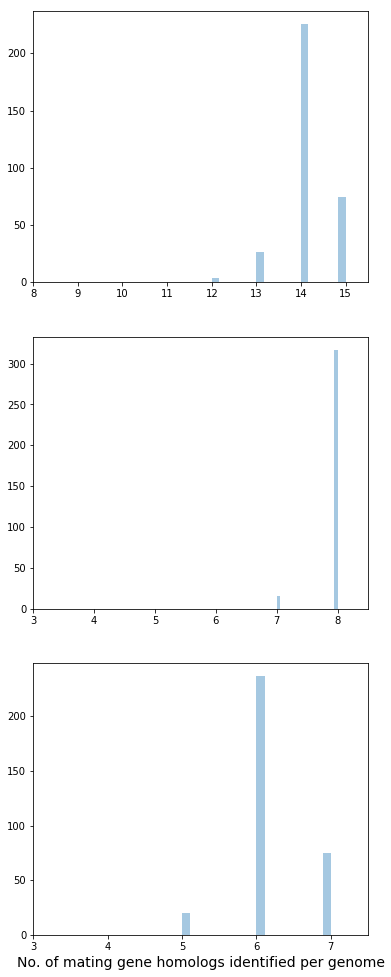

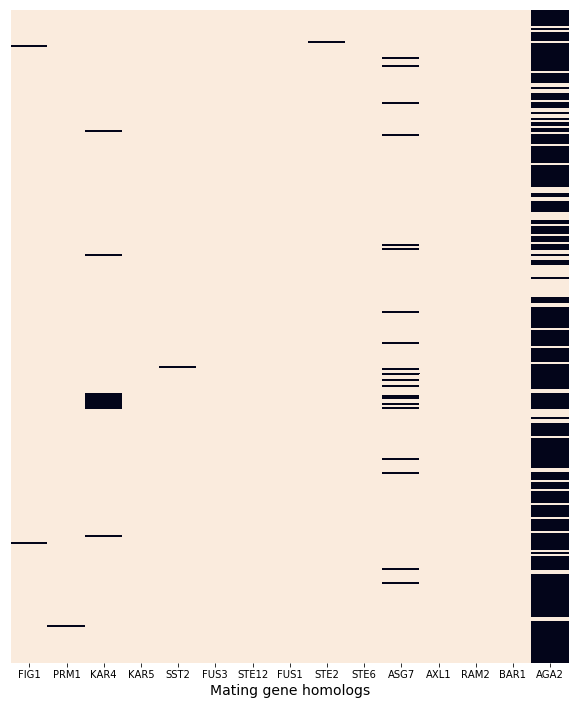

In [122]:
##Writing a quick script to read through the stats file for the identified homologs.
homolog_species_stats_file = os.path.join(data_dir, "hmmsearch_best_stats.csv")
homolog_species_stats = pd.read_csv(homolog_species_stats_file, sep="\t", index_col=0)
print(homolog_species_stats[['FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']].sum())
#promoter_species_stats.head()
print(list(homolog_species_stats.columns))

fig1 = figure(figsize=(6,17))
ax1 = subplot(311)
ax1 = sns.distplot(homolog_species_stats['Total'], kde=False, axlabel=False)
plt.xlim(8,15.5)

ax2 = subplot(312)
ax2 = sns.distplot(homolog_species_stats['pheromoneActivated'], kde=False, axlabel=False)
plt.xlim(3,8.5)

ax3 = subplot(313)
ax3 = sns.distplot(homolog_species_stats['aSpecific'], kde=False)
plt.xlim(3,7.5)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("No. of mating gene homologs identified per genome", fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_species_homologs_200428.png'), dpi=300, transparent=True)

homolog_species_stats_heatmap = homolog_species_stats[['FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']]
fig2 = figure(figsize=(10,12))
ax2 = sns.heatmap(homolog_species_stats_heatmap, cbar=False, yticklabels=False)
plt.xlabel("Mating gene homologs", fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_species_homologs-byGene_200428.png'), dpi=300, transparent=True)

### Code-chunk that is used to process promoters from fungal species (332 yeast)
This section has code blocks that perform the following functions:  
1. Function to pool the mating regulatory regions of species within the expected the time horizon where mating TF motifs are conserved. The time horizon was done by comparing the largest divergence time between species in clades from Sorrells et al, that showed conserved STE12 motif in aSpecific genes. This time horizon was identified in my 'pheromoneFinder_py3-testbed.ipynb' in the 'notebooks' folder.
  1. Copy of above function in order to pool the regulatory regions of the candidates identified by the other functions of {pheromoneFinder}. The groups are identified by the time horizon associated with the Saccharomyces clade from Sorrells.
2. Function to separate promoters of 'pheromoneActivatedGenes' & 'aSpecificGenes' as identified in my HMM dictionary file that was used to setup the hmmbuild and hmmsearch. These genes were identified in Sorrells et al and I've just mimiced the homolog discovery pipeline they described in their methods.
3. Function to measure statistic of the number of promoters identified for each file (species or phylogenetic clade/group) in the promoter folder. This is a validation table that will be needed for the paper's supplementary.
4. Function to strip (") characters from sequence IDs since it messes with the parsing of the xml output from meme.

In [29]:
##This block mimics the function of <pheromoneFinder/phyloGroup>, and has been modified to work on the promoters dir.
##The function has the following inputs:
    ###promoter_dir = The directory containing the fasta files of promoters. Each file corresponds to a species with the promoters of the mating gene homologs identified in that genome.
    ###phylogroup_regulation_list_dir = The directory containing .txt. files of the phhylogenetic groups that share a common ancestor before the time-horizon of mating regultion conservation.
tree_dir = os.path.join(data_dir, "tree")
candidate_promoter_dir = os.path.join(tree_dir, "promoters")
phylogroup_regulation_list_dir = os.path.join(tree_dir, "PhyloGroups_candidate_regulation")
phylogroup_regulation_file_list = [f for f in os.listdir(phylogroup_regulation_list_dir)]
#print(phylogroup_regulation_file_list)

for file_list in phylogroup_regulation_file_list:
    print("Working on ", file_list.split(".txt")[0], " that contains species that are presumed to share mating TF motifs.")
    speciesFileList = []
    #print inputHandle.readline()
    with open(os.path.join(phylogroup_regulation_list_dir, file_list), "r") as input_handle:
        speciesFileList = input_handle.read().split("\n")
        speciesFileList.remove("")
    #print(speciesFileList)
    
    print speciesFileList, "\n which contains ", len(speciesFileList), " species!\n"
    regulatory_phylo_group_candidates = []
    for speciesFile in speciesFileList:
        #This is to pool only the largest candidate per CAAX-Stop locus of Asn...CAAX-Stop candidates from speies within a PhyloGroup.
        input_file_handle = open(os.path.join(promoter_dir, speciesFile), "r")
        records = list(SeqIO.parse(input_file_handle, "fasta"))
        input_file_handle.close()
        
        ##Extending master list.
        regulatory_phylo_group_candidates.extend(records)
    
    print "Concatenated ", len(regulatory_phylo_group_candidates), " candidates in the ", file_list.split(".")[0], " phylogenetic group.\n"
    
    ##Making Output directory.
    if not(os.path.isdir(os.path.join(tree_dir, "PhyloGroup_promoters"))):
        os.mkdir(os.path.join(tree_dir, "PhyloGroup_promoters"))
    
    outputFile = os.path.join(tree_dir, "PhyloGroup_promoters", "promoters_0_"+file_list.split(".")[0]+".fasta")
    outputHandle = open(outputFile, "w")
    for candidate in regulatory_phylo_group_candidates:
        outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
    outputHandle.close()

('Working on ', 'phyloGroup_1', ' that contains species that are presumed to share mating TF motifs.')
['promoters_0_yHMPu5000041678_debaryomyces_prosopidis_160928.fasta', 'promoters_0_yHMPu5000041829_debaryomyces_fabryi_160928.fasta', 'promoters_0_yHMPu5000041824_debaryomyces_subglobosus_160928.fasta', 'promoters_0_debaryomyces_hansenii.fasta', 'promoters_0_yHMPu5000041693_debaryomyces_nepalensis_160928.fasta', 'promoters_0_yHMPu5000041713_debaryomyces_maramus_160928.fasta', 'promoters_0_millerozyma_acaciae.fasta'] 
 which contains  7  species!

Concatenated  98  candidates in the  phyloGroup_1  phylogenetic group.

('Working on ', 'phyloGroup_12', ' that contains species that are presumed to share mating TF motifs.')
['promoters_0_yHMPu5000034918_nakazawaea_holstii_160519.fasta', 'promoters_0_nakazawaea_peltata.fasta'] 
 which contains  2  species!

Concatenated  28  candidates in the  phyloGroup_12  phylogenetic group.

('Working on ', 'phyloGroup_13', ' that contains species that a

In [83]:
##This block mimics the function of <pheromoneFinder/phyloGroup>, and has been modified to work on the promoters dir.
##The function has the following inputs:
    ###promoter_dir = The directory containing the fasta files of promoters. Each file corresponds to a species with the promoters of the mating gene homologs identified in that genome.
    ###phylogroup_regulation_list_dir = The directory containing .txt. files of the phhylogenetic groups that share a common ancestor before the time-horizon of mating regultion conservation.
tree_dir = os.path.join(data_dir, "tree")
promoter_dir = os.path.join(tree_dir, "PromoterExtract")
phylogroup_regulation_list_dir = os.path.join(tree_dir, "PhyloGroups_candidate_regulation")
phylogroup_regulation_file_list = [f for f in os.listdir(phylogroup_regulation_list_dir) if os.path.isfile(os.path.join(tree_dir, "PhyloGroups_candidate_regulation", f))]
#print(phylogroup_regulation_file_list)

for file_list in phylogroup_regulation_file_list:
    print("Working on ", file_list.split(".txt")[0], " that contains species that are presumed to share mating TF motifs.")
    speciesFileList = []
    #print inputHandle.readline()
    with open(os.path.join(phylogroup_regulation_list_dir, file_list), "r") as input_handle:
        speciesFileList = input_handle.read().split("\n")        
        speciesFileList.remove("")
    #print(speciesFileList)
    
    print speciesFileList, "\n which contains ", len(speciesFileList), " species!\n"
    regulatory_phylo_group_candidates = []
    for speciesFile in speciesFileList:
        #This is to pool only the largest candidate per CAAX-Stop locus of Asn...CAAX-Stop candidates from speies within a PhyloGroup.
        input_file_handle = open(os.path.join(promoter_dir, speciesFile), "r")
        records = list(SeqIO.parse(input_file_handle, "fasta"))
        input_file_handle.close()
        
        ##Extending master list.
        regulatory_phylo_group_candidates.extend(records)
    
    print "Concatenated ", len(regulatory_phylo_group_candidates), " candidates in the ", file_list.split(".")[0], " phylogenetic group.\n"
    
    ##Making Output directory.
    if not(os.path.isdir(os.path.join(tree_dir, "PhyloGroup_candidate_promoters"))):
        os.mkdir(os.path.join(tree_dir, "PhyloGroup_candidate_promoters"))
    
    outputFile = os.path.join(tree_dir, "PhyloGroup_candidate_promoters", "promoters_0_candidates_0_"+file_list.split(".")[0]+".fasta")
    outputHandle = open(outputFile, "w")
    for candidate in regulatory_phylo_group_candidates:
        outputHandle.write(">"+str(candidate.id)+"\n"+str(candidate.seq)+"\n")
    outputHandle.close()

('Working on ', 'phyloGroup_1', ' that contains species that are presumed to share mating TF motifs.')
['yHMPu5000041678_debaryomyces_prosopidis_160928.fas.caax.asn.promoters', 'yHMPu5000041829_debaryomyces_fabryi_160928.fas.caax.asn.promoters', 'yHMPu5000041824_debaryomyces_subglobosus_160928.fas.caax.asn.promoters', 'debaryomyces_hansenii.fas.caax.asn.promoters', 'yHMPu5000041693_debaryomyces_nepalensis_160928.fas.caax.asn.promoters', 'yHMPu5000041713_debaryomyces_maramus_160928.fas.caax.asn.promoters', 'millerozyma_acaciae.fas.caax.asn.promoters'] 
 which contains  7  species!

Concatenated  2368  candidates in the  phyloGroup_1  phylogenetic group.

('Working on ', 'phyloGroup_12', ' that contains species that are presumed to share mating TF motifs.')
['yHMPu5000034918_nakazawaea_holstii_160519.fas.caax.asn.promoters', 'nakazawaea_peltata.fas.caax.asn.promoters'] 
 which contains  2  species!

Concatenated  789  candidates in the  phyloGroup_12  phylogenetic group.

('Working on ',

In [153]:
##I've decided to run MEME on the promoter collections by separating into those that corresponding to pheromone-activated genes and a-specific genes (as identified in Sorrells et al)
##The function will be writted to work on the directory of the promoter fasta files, read in each file scan through the records, check the seq.id and then append to twp different
##FASTA Lists depending on the seq.id.split("|/|") value.
###The input values into this function are:
    ###promoter_dir = This is the folder that contains the FASTA files of the promoters of different species or different phyloGroups
    ###hmm_dict_file = This is the dictionary file of the mating genes whoose homologs were found in various fungi. The genes belong to two classes: 'pheromoneActivatedGenes' & 'aSpecificGenes'
hmm_dict_file = os.path.join(hmm_dir, "Scer-matingGenes_phmmer_200416.csv")
promoter_dir = os.path.join(tree_dir, "promoters")

####Reading in the dictionary file into a pandqas dataframe
hmm_dict = pd.read_csv(hmm_dict_file)

promoter_fasta_file_list = [f for f in os.listdir(promoter_dir) if f.endswith(".fasta")]

for promoter_fasta_file in promoter_fasta_file_list:
    input_fasta_file_handle = open(os.path.join(promoter_dir, promoter_fasta_file), "r")
    records = list(SeqIO.parse(input_fasta_file_handle, "fasta"))
    input_fasta_file_handle.close()
    
    ####Making blank lists for the Bio.Seq.SeqRecord lists of 'pheromoneActivatedGenes' & 'aSpecificGenes'
    pheromone_activated_promoters = []
    a_specific_promoters = []
    
    for record in records:
        #print(record.id.split("|/|")[0].split(">")[-1])
        #print((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "pheromoneActivatedGenes")
        ####Adding the promoter to the appropriate file list.
        if ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "pheromoneActivatedGenes"):
            pheromone_activated_promoters.append(FASTAStructureMinimal(record.id, record.seq))
        elif ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "aSpecificGenes"):
            a_specific_promoters.append(FASTAStructureMinimal(record.id, record.seq))
    print("Done categorizing "+str(len(records))+" promoters from "+promoter_fasta_file.split(".fasta")[0]+".")
    
    ####Printing out the categorized fasta lists into their own directories.
    ####For 'pheromoneActivatedGenes'
    if not(os.path.isdir(os.path.join(promoter_dir, "..", "pheroAct_"+promoter_dir.split("/")[-1]))):
        os.mkdir(os.path.join(promoter_dir, "..", "pheroAct_"+promoter_dir.split("/")[-1]))
    output_dir = os.path.join(promoter_dir, "..", "pheroAct_"+promoter_dir.split("/")[-1])
    output_fasta_file_hasndle = open(os.path.join(output_dir, "pheroAct_"+promoter_fasta_file), "w")
    for promoter in pheromone_activated_promoters:
        output_fasta_file_hasndle.write(">"+str(promoter.id)+"\n"+str(promoter.seq)+"\n")
    output_fasta_file_hasndle.close()
    
    ####For 'aSpecificGenes'
    if not(os.path.isdir(os.path.join(promoter_dir, "..", "aSpec_"+promoter_dir.split("/")[-1]))):
        os.mkdir(os.path.join(promoter_dir, "..", "aSpec_"+promoter_dir.split("/")[-1]))
    output_dir = os.path.join(promoter_dir, "..", "aSpec_"+promoter_dir.split("/")[-1])
    output_fasta_file_hasndle = open(os.path.join(output_dir, "aSpec_"+promoter_fasta_file), "w")
    for promoter in a_specific_promoters:
        output_fasta_file_hasndle.write(">"+str(promoter.id)+"\n"+str(promoter.seq)+"\n")
    output_fasta_file_hasndle.close()

Done categorizing 14 promoters from promoters_0_alloascoidea_hylecoeti.
Done categorizing 14 promoters from promoters_0_ambrosiozyma_kashinagacola.
Done categorizing 14 promoters from promoters_0_ambrosiozyma_monospora.
Done categorizing 14 promoters from promoters_0_arxula_adeninivorans.
Done categorizing 14 promoters from promoters_0_ascoidea_asiatica.
Done categorizing 14 promoters from promoters_0_ascoidea_rubescens.
Done categorizing 14 promoters from promoters_0_ashbya_aceri.
Done categorizing 14 promoters from promoters_0_babjeviella_inositovora.
Done categorizing 15 promoters from promoters_0_brettanomyces_anomalus.
Done categorizing 14 promoters from promoters_0_candida_albicans.
Done categorizing 15 promoters from promoters_0_candida_apicola.
Done categorizing 14 promoters from promoters_0_candida_arabinofermentans.
Done categorizing 14 promoters from promoters_0_candida_auris.
Done categorizing 14 promoters from promoters_0_candida_boidinii_JCM9604.
Done categorizing 14 prom

In [155]:
##Function to read through the fasta files of promoters in a folder and output the list of promoters identified accross species or phylogenetic groups.
##The input values into this function are:
    ###promoter_dir = This is the folder that contains the FASTA files of the promoters of different species or different phyloGroups
    ###hmm_dict_file = This is the dictionary file of the mating genes whoose homologs were found in various fungi. The genes belong to two classes: 'pheromoneActivatedGenes' & 'aSpecificGenes'
hmm_dict_file = os.path.join(hmm_dir, "Scer-matingGenes_phmmer_200416.csv")
promoter_dir = os.path.join(tree_dir, "promoters")

####Reading in the dictionary file into a pandqas dataframe
hmm_dict = pd.read_csv(hmm_dict_file)

promoter_fasta_file_list = [f for f in os.listdir(promoter_dir) if f.endswith(".fasta")]
promoter_stats = pd.DataFrame()

for promoter_fasta_file in promoter_fasta_file_list:
    input_fasta_file_handle = open(os.path.join(promoter_dir, promoter_fasta_file), "r")
    records = list(SeqIO.parse(input_fasta_file_handle, "fasta"))
    input_fasta_file_handle.close()
    
    ####Making a blank dict for the promoter stats of the current file.
    promoter_key = ["phylogeneticName", "Total", "pheromoneActivated", "aSpecific"] + list(hmm_dict['GeneName'].values)
    ###print(promoter_key) == 
    ###['Total', 'pheromoneActivated', 'aSpecific', 'FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']
    promoter_stats_dict = collections.OrderedDict()
    for column in promoter_key:
        promoter_stats_dict[column] = 0
    ###print(promoter_stats_dict)
    
    for record in records:
        ####Checking the promoter identity to appropriately record the stats.
        if ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "pheromoneActivatedGenes"):
            promoter_stats_dict['pheromoneActivated'] += 1
        elif ((hmm_dict[hmm_dict['GeneName'] == record.id.split("|/|")[0].split(">")[-1]]['Category'].values) == "aSpecificGenes"):
            promoter_stats_dict['aSpecific'] += 1
        promoter_stats_dict[record.id.split("|/|")[0].split(">")[-1]] +=1
        promoter_stats_dict['Total'] += 1
    promoter_stats_dict['phylogeneticName'] = promoter_fasta_file.split(".fasta")[0].split("_0_")[-1]
    promoter_stats_temp_frame = pd.DataFrame(promoter_stats_dict, index=[0])
    ###print("Done categorizing "+str(len(records))+" promoters from "+promoter_fasta_file.split(".fasta")[0]+".")
    promoter_stats = promoter_stats.append(promoter_stats_temp_frame, ignore_index=True)
    ###print(promoter_stats)
output_csv_file = os.path.join(promoter_dir, "..", promoter_dir.split("/")[-1]+"_stats.csv")
promoter_stats.to_csv(output_csv_file, sep="\t", header=True)
print("Done analyzing "+str(len(promoter_stats))+" phylogenetic group\'s promoters and made the statstics file "+output_csv_file+" .")

Done analyzing 332 phylogenetic group's promoters and made the statstics file ../tree/promoters/../promoters_stats.csv .


['phylogeneticName', 'Total', 'pheromoneActivated', 'aSpecific', 'FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']


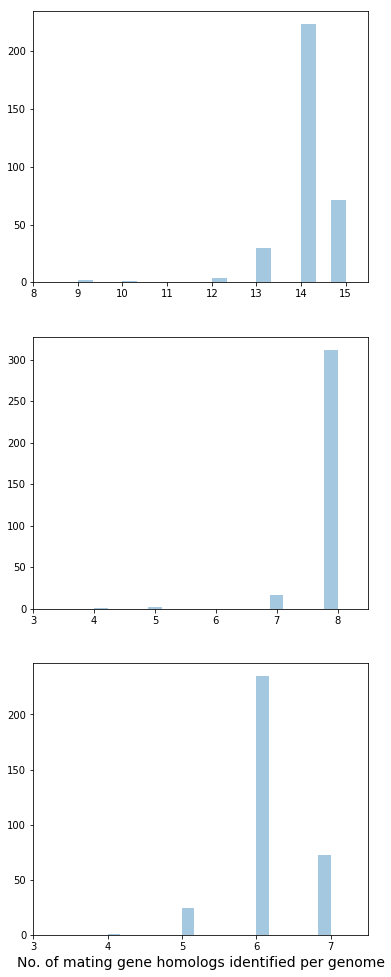

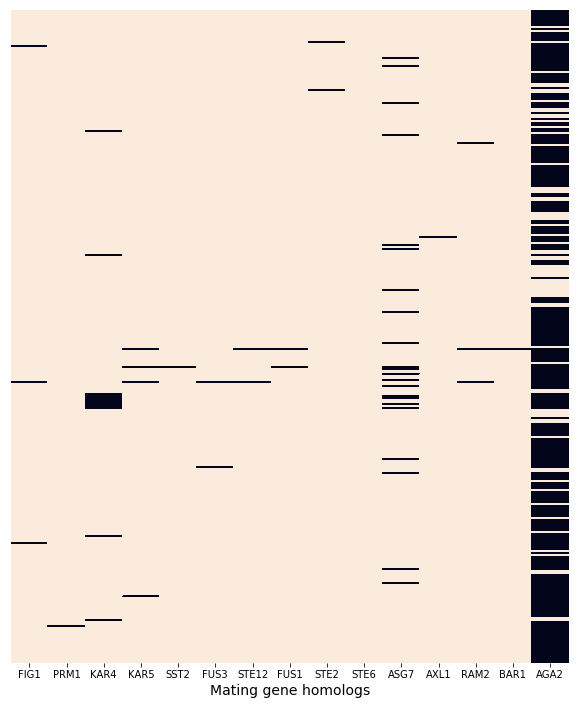

In [90]:
##Writing a quick script to read through the stats file for the identified promoters.
promoter_species_stats_file = os.path.join(data_dir, "tree", "promoters_stats.csv")
promoter_species_stats = pd.read_csv(promoter_species_stats_file, sep="\t", index_col=0)

#promoter_species_stats.head()
print(list(promoter_species_stats.columns))

fig1 = figure(figsize=(6,17))
ax1 = subplot(311)
ax1 = sns.distplot(promoter_species_stats['Total'], kde=False, axlabel=False)
plt.xlim(8,15.5)

ax2 = subplot(312)
ax2 = sns.distplot(promoter_species_stats['pheromoneActivated'], kde=False, axlabel=False)
plt.xlim(3,8.5)

ax3 = subplot(313)
ax3 = sns.distplot(promoter_species_stats['aSpecific'], kde=False)
plt.xlim(3,7.5)
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("No. of mating gene homologs identified per genome", fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_species_promoters_200428.png'), dpi=300, transparent=True)

promoter_species_stats_heatmap = promoter_species_stats[['FIG1', 'PRM1', 'KAR4', 'KAR5', 'SST2', 'FUS3', 'STE12', 'FUS1', 'STE2', 'STE6', 'ASG7', 'AXL1', 'RAM2', 'BAR1', 'AGA2']]
fig2 = figure(figsize=(10,12))
ax2 = sns.heatmap(promoter_species_stats_heatmap, cbar=False, yticklabels=False)
plt.xlabel("Mating gene homologs", fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_species_promoters-byGene_200428.png'), dpi=300, transparent=True)

In [150]:
#Osolete code since this functionality has been incorporated into the matingGeneHomologPromoters function/code-cell.
# ##Function to read through the fasta files of promoters in a folder and output the promoter FASTA files after stripping (") character in the sequence IDs.
# ##I am going to incorporate this replacement directly in the <pheromoneFinder/matingGeneHomologPromoters> function, tested here and now made changes to the function in the python script
# ##of the cluster and also in the corresponding code-block above.
# ##The input values into this function are:
#     ###promoter_dir = This is the folder that contains the FASTA files of the promoters of different species or different phyloGroups
# promoter_dir = os.path.join(tree_dir, "../promoters")
# promoter_fasta_file_list = [f for f in os.listdir(promoter_dir) if f.endswith(".fasta")]

# if not(os.path.isdir(os.path.join(tree_dir, "../promoters_corr"))):
#     os.mkdir(os.path.join(tree_dir, "../promoters_corr"))

# corrected_promoter_dir = os.path.join(tree_dir, "../promoters_corr")

# for promoter_fasta_file in promoter_fasta_file_list:
#     input_fasta_file_handle = open(os.path.join(promoter_dir, promoter_fasta_file), "r")
#     records = list(SeqIO.parse(input_fasta_file_handle, "fasta"))
#     input_fasta_file_handle.close()
    
#     output_fasta_file_hasndle = open(os.path.join(corrected_promoter_dir, promoter_fasta_file), "w")
#     for promoter in records:
#         output_fasta_file_hasndle.write(">"+str(promoter.id.replace('"', ''))+"\n"+str(promoter.seq)+"\n")
#     output_fasta_file_hasndle.close()

----
1. I've managed to write a decent bit of code blocks to parse the promoters of presumed (hmmsearch + tBLASTN) mating gene homologs from the 332 fungal genomes in Saccharomycotina that I started with. Additionally I estimated the time horizon of mating TF motif conservation to be 180 units along the rel_time tree from Shen XX et al, Cell (2018) corresponding to the time of the last common ancestor of the Saccharomyces lineage as described in Sorrells TR et al, Nature (2016). 
2. The promoters are now in different directories under the 'tree' folder and can be moved to the 'meme' folder for further analysis. Eventually I want all of these to be added as functions to the base <pheromoneFinder.py> code-base I have.
3. There are 37 phylogenetic groups identified with the Sorrells time-horizon that have at least 2 species within them.
----
----

### Using meme wrapper to identify motifs in promoters using MEME-5.1.1 locally
Started on [20200423], wrapper from Peter Culviner (github.com/peterculviner)
1. Initially wrote the function to loop through the promoters identified from S. cerevisiae and the Saccharomyces clade (phylogroup 27).
2. I have modified the wrapper from peter to ouput to directories with the name of the corresponding input_promoters_fasta_file in a new directory 'meme_temp' in the base folder (above the dir containing the fasta files.)
3. I need to figure out how to best output the motifs identified by MEME in order to use them for a MAST search against the promoters that I have found in the corresponding clades. I need to repeat the <pheromoneFinder/phyloGroupCandidates> function on species pheromone candidates (.fas.caax.asn files) with the phyloGroups made with regulation to see if I find the motifs upstream of the pheromone candidates identified in the clades where regulation is expected to be conserved.
  1. From the web-server there seems to be a form of output for each motif that is a .txt file that can be read in by MAST but from the 'meme -h' that I have run below there is no obvious command to get this output. So I am an idiot; the full .txt output file is what can read in by FIMO and other programs.
  
##### Functions in this code-section:
1. Running MEME-5.1.1 by using the wrapper from Peter Culviner. I've modified his wrapper to save outputs, one for each input promoter_fasta_file in the 'meme_temp' directory. This is especially important since the meme.txt output file is what I need to use as an input into FIMO.
2. Efforts to convert MEME output to the minimal MEME txt output are obsolete since I can use the full output file as the input to FIMO.
3. Function to analyze the MEME outputs and give me a CSV for further plotting and analysis.
  1. Function to plot results from MEME runs across species and phylogenetic groups.
4. Function to test FIMO locally is not great since the fimo binary seems to have a bug where I get a "buffer overflow; core dumped" error message. I have verified that the meme-suite module on Odyssey 2.0 (bio/meme-4.9.0_4) functions well, I am going to write code to run these on the server directly.
5. Function to analyze the results of FIMO run with the motifs from mating gene promoters against the promoters (upstream 1000bp) of candidates identified in the same species or phylogenetic group (where regulatory motifs are expected to be conserved, e.g. Saccharomyces)

In [160]:
##This is a quick code-block to test the meme run on S. cerevisiae mating promoters and also the phylogroup containing S. cerevisiae,
##(phyloGroup_27, this corresponds to Saccharomyces from Sorrells).
##I need to figure out what the ouput is to these functions.
meme_dir = os.path.join(data_dir, "meme")
meme_fasta_dir = os.path.join(meme_dir, "PhyloGroup_promoters")
meme_fasta_file_list = [f for f in os.listdir(meme_fasta_dir) if (f.endswith(".fasta"))]
print("The fasta files on which I need to run MEME are:")
print("\n".join(meme_fasta_file_list))

for meme_fasta_file in meme_fasta_file_list:
    if (meme_fasta_file.startswith("promoters_0_")):
        print("\nWorking on the promoters of "+meme_fasta_file.split(".fasta")[0].split("promoters_0_")[-1]+".")
    elif (meme_fasta_file.startswith("aSpec_promoters_0") or meme_fasta_file.startswith("pheroAct_promoters_0")):
        print("\nWorking on the "+meme_fasta_file.split(".fasta")[0].split("_")[0]+" promoters of "+meme_fasta_file.split(".fasta")[0].split("promoters_0_")[-1]+".")
    motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies = memewrapper(os.path.join(meme_fasta_dir, meme_fasta_file))
    print(motif_details)
    print(motif_regex)

The fasta files on which I need to run MEME are:
promoters_0_phyloGroup_1.fasta
promoters_0_phyloGroup_12.fasta
promoters_0_phyloGroup_13.fasta
promoters_0_phyloGroup_14.fasta
promoters_0_phyloGroup_15.fasta
promoters_0_phyloGroup_17.fasta
promoters_0_phyloGroup_19.fasta
promoters_0_phyloGroup_2.fasta
promoters_0_phyloGroup_20.fasta
promoters_0_phyloGroup_21.fasta
promoters_0_phyloGroup_24.fasta
promoters_0_phyloGroup_25.fasta
promoters_0_phyloGroup_26.fasta
promoters_0_phyloGroup_27.fasta
promoters_0_phyloGroup_28.fasta
promoters_0_phyloGroup_3.fasta
promoters_0_phyloGroup_30.fasta
promoters_0_phyloGroup_31.fasta
promoters_0_phyloGroup_32.fasta
promoters_0_phyloGroup_35.fasta
promoters_0_phyloGroup_36.fasta
promoters_0_phyloGroup_37.fasta
promoters_0_phyloGroup_38.fasta
promoters_0_phyloGroup_4.fasta
promoters_0_phyloGroup_42.fasta
promoters_0_phyloGroup_44.fasta
promoters_0_phyloGroup_46.fasta
promoters_0_phyloGroup_5.fasta
promoters_0_phyloGroup_50.fasta
promoters_0_phyloGroup_52.fa

In [130]:
##Function to test output of MEME by parsexml and use matrix2meme to produce a MOTIF txt file for use with FIMO.
meme_xml_base_dir = os.path.join(meme_dir, "meme_output")
meme_output_dir_list = [d for d in os.listdir(meme_xml_base_dir) if (os.path.isdir(os.path.join(meme_xml_base_dir, d)) and not(d.startswith(".")))]

#print(meme_output_dir_list)
for meme_output_dir in meme_output_dir_list:
    motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies = parsememexml(os.path.join(meme_xml_base_dir, meme_output_dir, 'meme.xml'))
    print([str(i) for i in (motif_frequencies[0])])
    
    ##This was my attempt to output the freq matrix of motifs from the XML output of meme into ASCII files to use matrix2meme. Turns out FIMO can use the .txt output of MEME directly
    ##as a motif file. So this is not relevant.
    #ouput_dir = meme_xml_base_dir
    #output_handle = open(os.path.join(meme_xml_base_dir, "test.out"), "w")
    #for row in motif_frequencies[0]:
    #    for element in row:
    #        output_handle.write(str(element)+"\t")
    #    output_handle.write("\n")
    #output_handle.close()
    
    xml_path = os.path.join(meme_xml_base_dir, meme_output_dir, "meme.xml")
    open_xml = ET.parse(xml_path)
    found_motifs = open_xml.getroot().find('motifs')
    for motif in found_motifs:
        print(motif.attrib['name']+"\t"+motif.attrib['width']+"\t"+motif.attrib['e_value']+"\t"+motif.attrib['p_value'])
        
        sys.exit()

['[0. 0. 1. 0.]', '[0. 0. 1. 0.]', '[0.602041 0.397959 0.       0.      ]', '[1. 0. 0. 0.]', '[0.877551 0.071429 0.05102  0.      ]', '[0.091837 0.897959 0.010204 0.      ]', '[0.081633 0.877551 0.040816 0.      ]', '[0.       0.989796 0.010204 0.      ]', '[0.989796 0.       0.010204 0.      ]', '[0. 0. 0. 1.]']
GGWAATTTAC	10	7.1e-037	6.2e-257


SystemExit: 

In [4]:
##Function to scan through the meme_output_dir, read through the meme.xml output in the directory for each meme run and outputting the relevant parameters into a csv file.
##The goal of this is to get appropriate statistics of the different meme_outputs from the mating gene promoter fasta files.
##Columns = ['PhylogeneticName', 'Category', 'Motif#', 'MotifName', 'MotifWidth', 'MotifeVal', 'MotifpVal', 'MotifRegex']
##The input files are the following:
    ###meme_output_dir = The base directory containing the outputs from MEME.
meme_output_dir = os.path.join(data_dir, "meme", "meme_output")
meme_cat_dir_list = [d for d in os.listdir(meme_output_dir) if (os.path.isdir(os.path.join(meme_output_dir, d)) and not(d.startswith(".")))]
#print(meme_cat_dir_list)

for meme_cat_dir in meme_cat_dir_list:
    ###Defining a dataframe for the statistics.
    meme_stats = pd.DataFrame()
    dict_key = ['PhylogeneticName', 'Category', 'Motif#', 'MotifName', 'MotifWidth', 'MotifeVal', 'MotifRegex']
    meme_promoter_stats_dict = collections.OrderedDict()
    for column in dict_key:
        meme_promoter_stats_dict[column] = 0
    
    meme_run_dir_list = [d for d in os.listdir(os.path.join(meme_output_dir, meme_cat_dir)) if (os.path.isdir(os.path.join(meme_output_dir, meme_cat_dir, d)))]
    #print(meme_run_dir_list)
    temp_cat_dir = os.path.join(meme_output_dir, meme_cat_dir)
    for meme_run_dir in meme_run_dir_list:
        ###Running the MEME XML parser to extract the motifs and their statistics.
        if os.path.isfile(os.path.join(temp_cat_dir, meme_run_dir, 'meme.xml')):
            motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies = parsememexml(os.path.join(temp_cat_dir, meme_run_dir, 'meme.xml'))
            
            #print(motif_details)
            for motif_number in range(len(motif_details)):
                ##Intializing empty dictionary for each motif.
                meme_promoter_stats_dict = collections.OrderedDict()
                for column in dict_key:
                    meme_promoter_stats_dict[column] = 0
                
                #print(motif_details[motif_number])
                ###Specifying all relevant values for dictionary.
                ####For 'PhylogeneticName' from the output directory name
                meme_promoter_stats_dict['PhylogeneticName'] = meme_run_dir.rstrip("/").split("promoters_0_")[-1]
                
                ####For the 'Category' from the start of the output directory name
                #print(meme_run_dir.rstrip("/").split("_")[0])
                if (meme_run_dir.rstrip("/").split("_")[0] == "promoters"):
                    meme_promoter_stats_dict['Category'] = "All"
                else:
                    meme_promoter_stats_dict['Category'] = meme_run_dir.rstrip("/").split("_")[0]
                
                ####For the 'Motif#', the loop number of the motif.
                meme_promoter_stats_dict['Motif#'] = motif_number
                
                ####For the 'MotifName', 'MotifWidth', 'MotifeVal', 'MotifpVal' & 'MotifRegex' the details from parsememexml
                meme_promoter_stats_dict['MotifName'] = motif_details[motif_number][0]
                meme_promoter_stats_dict['MotifWidth'] = motif_details[motif_number][1]
                meme_promoter_stats_dict['MotifeVal'] = motif_details[motif_number][2]
                #meme_promoter_stats_dict['MotifpVal'] = motif_details[motif_number][3] #Not present in the meme-4.9.0 run.
                meme_promoter_stats_dict['MotifRegex'] = motif_regex[motif_number]
                
                meme_stats = meme_stats.append(pd.DataFrame(meme_promoter_stats_dict, index=[0]), ignore_index=True)
                #print(meme_stats)
                
        else:
            print("Missing MEME output for "+str(meme_run_dir.rstrip("/"))+", no results will be saved.")
    
    ###The sorting is done by string sortin, this is unfortunate since phylogroup_10 is close to phylogroup_1, what I would ideally like is apparently called a "human sort" (https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside)
    ###I couldn't figure out a way to use my own sorting function in a dataframe and this doesn't seem like the thing I should spend my time on.
    meme_stats = meme_stats.sort_values(by=['PhylogeneticName', 'Category', 'Motif#']).reset_index(drop=True)
    
    output_csv_file = os.path.join(meme_output_dir, meme_cat_dir.rstrip("/")+"_meme-stats.csv")
    meme_stats.to_csv(output_csv_file, sep="\t", header=True)
    print("Done analyzing "+str(len(meme_stats))+" motif\'s from "+
          str(len([d for d in os.listdir(os.path.join(meme_output_dir, meme_cat_dir)) if (os.path.isdir(os.path.join(meme_output_dir, meme_cat_dir, d)) and d.startswith("promoters_0_"))]))+
          " group\'s promoters, also with "+
          str(len([d for d in os.listdir(os.path.join(meme_output_dir, meme_cat_dir)) if (os.path.isdir(os.path.join(meme_output_dir, meme_cat_dir, d)) and d.startswith("aSpec"))]))+
          " group\'s promoters of a-specific genes and "+
          str(len([d for d in os.listdir(os.path.join(meme_output_dir, meme_cat_dir)) if (os.path.isdir(os.path.join(meme_output_dir, meme_cat_dir, d)) and d.startswith("pheroAct"))]))+
          " group\'s promoters of pheromone-activated genes. All the data has been saved to the statstics file in the meme_output directory, "+output_csv_file.rstrip(".csv")+".")

Done analyzing 333 motif's from 37 group's promoters, also with 37 group's promoters of a-specific genes and 37 group's promoters of pheromone-activated genes. All the data has been saved to the statstics file in the meme_output directory, ../meme/meme_output/phyloGroup_meme-stat.
Done analyzing 117 motif's from 37 group's promoters, also with 1 group's promoters of a-specific genes and 1 group's promoters of pheromone-activated genes. All the data has been saved to the statstics file in the meme_output directory, ../meme/meme_output/phyloGroup_local_200428_meme-stat.
Done analyzing 2988 motif's from 332 group's promoters, also with 332 group's promoters of a-specific genes and 332 group's promoters of pheromone-activated genes. All the data has been saved to the statstics file in the meme_output directory, ../meme/meme_output/species_meme-stat.
Done analyzing 2988 motif's from 332 group's promoters, also with 332 group's promoters of a-specific genes and 332 group's promoters of phero

In [37]:
motif_details, motif_scores, motif_frequencies, motif_regex, counts, bg_frequencies = parsememexml(os.path.join(temp_cat_dir, "aSpec_promoters_0_alloascoidea_hylecoeti", 'meme.xml'))
print(motif_regex)

['CACTTGCAT[GT]', 'GAG[CG]CACTG', '[GT]CC[TA][CG]GG[AT][GC]']


['PhylogeneticName', 'Category', 'Motif#', 'MotifName', 'MotifWidth', 'MotifeVal', 'MotifRegex']
['All' 'aSpec' 'pheroAct']
['PhylogeneticName', 'Category', 'Motif#', 'MotifName', 'MotifWidth', 'MotifeVal', 'MotifRegex']
['All' 'aSpec' 'pheroAct']
    PhylogeneticName  Category  Motif#  MotifName  MotifWidth      MotifeVal  \
117    phyloGroup_27       All       0          1          10  1.500000e-109   
118    phyloGroup_27       All       1          2          10   1.600000e-29   
119    phyloGroup_27       All       2          3          10   2.900000e-20   
120    phyloGroup_27     aSpec       0          1          10   8.600000e-62   
121    phyloGroup_27     aSpec       1          2          10   9.100000e-49   
122    phyloGroup_27     aSpec       2          3          10   2.200000e-31   
123    phyloGroup_27  pheroAct       0          1          10   1.800000e-77   
124    phyloGroup_27  pheroAct       1          2          10   4.800000e-22   
125    phyloGroup_27  pheroAct  

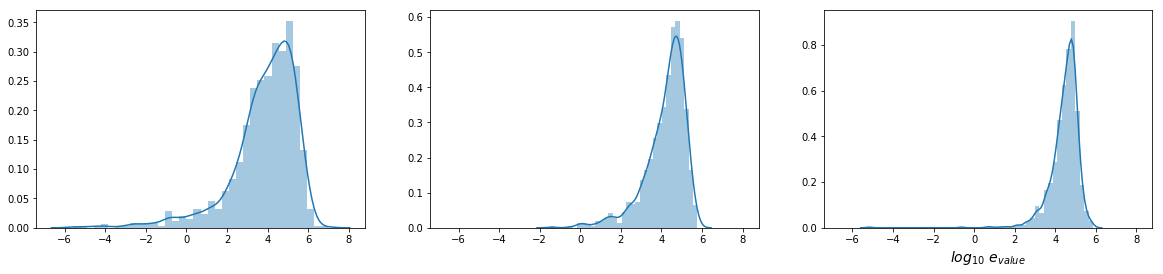

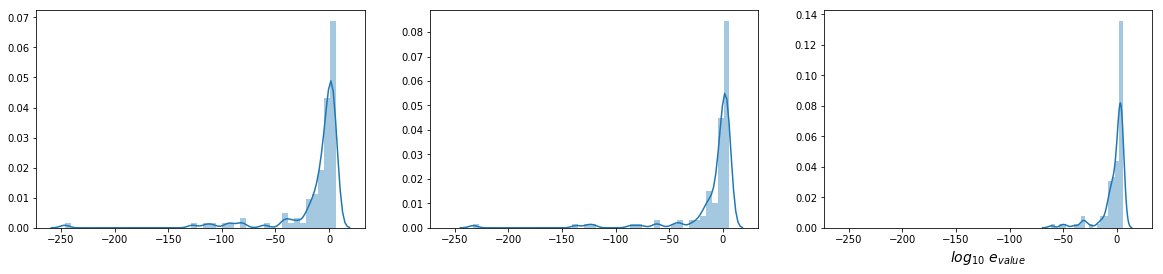

In [19]:
##Plotting some statistics from the MEME-4.9.0 run on Odyssey across species and phylogenetic groups.
meme_species_stats_file = os.path.join(data_dir, "meme", "meme_output", "species_meme-stats.csv")
meme_species_stats = pd.read_csv(meme_species_stats_file, sep="\t", index_col=0)
print(list(meme_species_stats.columns))
print(meme_species_stats['Category'].unique())

#meme_species_stats.head()
fig1 = figure(figsize=(20,4))
ax1 = subplot(131)
ax1 = sns.distplot(np.log10(meme_species_stats[meme_species_stats['Category'] == 'All']['MotifeVal']), axlabel=False)
plot_limits = plt.xlim()

ax2 = subplot(132)
ax2 = sns.distplot(np.log10(meme_species_stats[meme_species_stats['Category'] == 'pheroAct']['MotifeVal']), axlabel=False)
plt.xlim(plot_limits)

ax3 = subplot(133)
ax3 = sns.distplot(np.log10(meme_species_stats[meme_species_stats['Category'] == 'aSpec']['MotifeVal']))
plt.xlim(plot_limits)
plt.xlabel(r'$log_{10}\ e_{value}$', fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_species_MEME-eValues_200502.png'), dpi=300, transparent=True)

meme_phylogroup_stats_file = os.path.join(data_dir, "meme", "meme_output", "phyloGroup_meme-stats.csv")
meme_phylogroup_stats = pd.read_csv(meme_phylogroup_stats_file, sep="\t", index_col=0)
print(list(meme_phylogroup_stats.columns))
print(meme_phylogroup_stats['Category'].unique())

print(meme_phylogroup_stats[meme_phylogroup_stats['PhylogeneticName'] == 'phyloGroup_27'])
#meme_phylogroup_stats.head()
fig2 = figure(figsize=(20, 4))
ax21 = subplot(131)
ax21 = sns.distplot(np.log10(meme_phylogroup_stats[meme_phylogroup_stats['Category'] == 'All']['MotifeVal']), axlabel=False)
plot_limits = plt.xlim()

ax22 = subplot(132)
ax22 = sns.distplot(np.log10(meme_phylogroup_stats[meme_phylogroup_stats['Category'] == 'pheroAct']['MotifeVal']), axlabel=False)
plt.xlim(plot_limits)

ax23 = subplot(133)
ax23 = sns.distplot(np.log10(meme_phylogroup_stats[meme_phylogroup_stats['Category'] == 'aSpec']['MotifeVal']))
plt.xlim(plot_limits)
plt.xlabel(r'$log_{10}\ e_{value}$', fontsize=14);
#savefig(os.path.join(figure_dir, '332yeast_phylogroup_MEME-eValues_200502.png'), dpi=300, transparent=True)

In [31]:
##Function to run FIMO on candidate promoters with the MEME ouput of the mating gene promoters from the same phylogroups. The code-cell will be written to loop through the directory
##of the candidate promoters and find the appropriate MEME output for the mating gene promoters from the species or phyloGroup. I need to figure out what the output for this code will
##be, either the raw output of FIMO or ingest it and convert to a DataFrame that gives motifs-per-candidate-promoter.
##I am going to write wrappers for running FIMO and also to parse the outputs from the FIMO run (following what I borrowed from Peter for MEME).
###Input variables are:
    ###meme_input_base_dir = This is the directory that contains all the meme_outputs (meme.txt) with the directory names corresponding to the mating gene promoter groups.
    ###candidate_promoter_dir = This is the directory that contains all the FASTA files of candidate promoters from species OR phyloGroups.
fimo_dir = os.path.join(data_dir, "fimo")
if not(os.path.join(fimo_dir, "fimo_output")):
    os.mkdir(os.path.join(fimo_dir, "fimo_output"))
fimo_base_output_dir = os.path.join(fimo_dir, "fimo_output")

meme_input_base_dir = os.path.join(data_dir, "meme", "meme_output") ##Used only for local run since I don't want to replicate the meme_output folder. On the cluster I can use the MEME folder directly.
if not(os.path.isdir(meme_input_base_dir)):
    print("Make sure the directory with MEME outputs is present in the base directory as "+str(meme_input_base_dir)+"!")
candidate_promoter_dir = os.path.join(fimo_dir, "PromoterExtract") ##Used only the local run, provided as input on the cluster script.
if not(os.path.isdir(candidate_promoter_dir)):
    print("Make sure the directory with candidate promoter inputes is present in the base directory as "+str(candidate_promoter_dir)+"!")

candidate_promoter_file_list = [f for f in os.listdir(candidate_promoter_dir) if (f.endswith(".fasta") or f.endswith(".promoters"))]
print("Working on "+str(len(candidate_promoter_file_list))+" promoter files in "+str(candidate_promoter_dir)+".")
for candidate_promoter_file in candidate_promoter_file_list:
    ###Motifs from all mating gene promoters.
    ###Identifying input directory as containing species or phyloGroup candidate promoters
    ###Check the meme.txt file exists for the input candidate promoter file of species or phyloGroup.
    if (candidate_promoter_dir.split("_")[0] == "PhyloGroup"):
        category = "phyloGroup"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, candidate_promoter_file.split(".")[0], "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, candidate_promoter_file.split(".")[0], "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, candidate_promoter_file.split(".")[0], "meme.txt")
    else:
        category = "species"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, "promoters_0_"+str(candidate_promoter_file.split(".")[0]), "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, "promoters_0_"+str(candidate_promoter_file.split(".")[0]), "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, "promoters_0_"+str(candidate_promoter_file.split(".")[0]), "meme.txt")
    
    ###Running FIMO command.
    print("#-#-#-")
    print("Running FIMO on "+str(os.path.join(candidate_promoter_dir, candidate_promoter_file))+" with MEME motif file "+str(meme_motif_input_file)+"!")
    fimo_stderr, fimo_stdout = fimowrapper(os.path.join(candidate_promoter_dir, candidate_promoter_file), meme_motif_input_file)
    print("Standard error of FIMO run:\t")
    print(fimo_stderr.decode('utf-8'))
    print("Standard output of FIMO run:\t")
    print(fimo_stdout.decode('utf-8'))
    print("------\n")
    
    ###Motifs from pheroAct mating gene promoters.
    ###Identifying input directory as containing species or phyloGroup candidate promoters
    ###Check the meme.txt file exists for the input candidate promoter file of species or phyloGroup.
    if (candidate_promoter_dir.split("_")[0] == "PhyloGroup"):
        category = "phyloGroup"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.txt")
    else:
        category = "species"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt")
    
    ###
    print("Running FIMO on "+str(os.path.join(candidate_promoter_dir, candidate_promoter_file))+" with MEME motif file "+str(meme_motif_input_file)+"!")
    fimo_stderr, fimo_stdout = fimowrapper(os.path.join(candidate_promoter_dir, candidate_promoter_file), meme_motif_input_file)
    print("Standard error of FIMO run:\t")
    print(fimo_stderr.decode('utf-8'))
    print("Standard output of FIMO run:\t")
    print(fimo_stdout.decode('utf-8'))
    print("------\n")
    
    ###Motifs from aSpec mating gene promoters.
    ###Identifying input directory as containing species or phyloGroup candidate promoters
    ###Check the meme.txt file exists for the input candidate promoter file of species or phyloGroup.
    if (candidate_promoter_dir.split("_")[0] == "PhyloGroup"):
        category = "phyloGroup"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.txt")
    else:
        category = "species"
        if not(os.path.isfile(os.path.join(meme_input_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt"))):
            print("MEME motif file "+str(os.path.join(meme_input_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt"))+" is missing!")
        meme_motif_input_file = os.path.join(meme_input_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.txt")
    
    ###
    print("Running FIMO on "+str(os.path.join(candidate_promoter_dir, candidate_promoter_file))+" with MEME motif file "+str(meme_motif_input_file)+"!")
    fimo_stderr, fimo_stdout = fimowrapper(os.path.join(candidate_promoter_dir, candidate_promoter_file), meme_motif_input_file)
    print("Standard error of FIMO run:\t")
    print(fimo_stderr.decode('utf-8'))
    print("Standard output of FIMO run:\t")
    print(fimo_stdout.decode('utf-8'))
    print("------\n")
    sys.exit()

Working on 332 promoter files in ../fimo/PromoterExtract.
#-#-#-
Running FIMO on ../fimo/PromoterExtract/alloascoidea_hylecoeti.fas.caax.asn.promoters with MEME motif file ../meme/meme_output/species/promoters_0_alloascoidea_hylecoeti/meme.txt!
Standard error of FIMO run:	

Standard output of FIMO run:	
Using motif +1 of width 10.
Using motif -1 of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=1
Using motif +2 of width 10.
Using motif -2 of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.970692
Using motif +3 of width 10.
Using motif -3 of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.955921

------

Running FIMO on ../fimo/PromoterExtract/alloascoidea_hylecoeti.fas.caax.asn.promoters with MEME motif file ../meme/meme_output/speci

SystemExit: 

In [5]:
##Function to read in FIMO output from the run on the cluster to score candidates based on shared mating regulatory motifs.
##This function is going to read-in the tab-separated output file from FIMO (fimo-4.9.0 run on Odyssey) as pd.DataFrames and then pool motif hits into a scoring schema. The goal will 
##be to cycle through all the candidates from the FASTA file of candidates promoters and record the occurence of motifs identified as significant (with a particular p_value (<1e-04))
##in a new pd.DataFrame.
    ###candidate_promoter_dir = Directory containing the FASTA files of candidate promoters from either species or phylogenetic groups with conserved mating regulation
    ###meme_motif_base_dir = Base directory containing the outputs of the MEME runs on mating gene promoters in order read in the motifs that are tested.
    ###fimo_output_base_dir = Base directory containing the outputs of the FIMO runs of motifs from mating gene promoters against candidate promoters.
####Defining input variable directories for the function, and testing their existence
candidate_promoter_dir = os.path.join(data_dir, "fimo", "PhyloGroup_PromoterExtract")
if not(os.path.isdir(candidate_promoter_dir)):
    print("Directory containing candidate promoter FASTA files is missing at: "+str(candidate_promoter_dir))
    sys.exit()

meme_motif_base_dir = os.path.join(data_dir, "meme", "meme_output")
if not(os.path.isdir(meme_motif_base_dir)):
    print("Directory containing the outputs of MEME to identify motifs in mating gene promoters is missing at: "+str(meme_motif_base_dir))
    sys.exit()
    
fimo_output_base_dir = os.path.join(data_dir, "fimo", "fimo_output")
if not(os.path.isdir(fimo_output_base_dir)):
    print("Directory containing outputs of FIMO to find mating gene motifs in pheromone candidate promoters is missing at: "+str(fimo_output_base_dir))
    sys.exit()
    
####Looping through species OR phylogenetic groups of candidate promoter FASTA files to analyze the results one at a time.
candidate_promoter_file_list = [f for f in os.listdir(candidate_promoter_dir) if (f.endswith(".promoters") or f.endswith(".fasta"))]
for candidate_promoter_file in candidate_promoter_file_list:
    ###Reading in FASTA file to setup a SeqIO record list.
    input_file_handle = open(os.path.join(candidate_promoter_dir, candidate_promoter_file), "r")
    promoter_records = list(SeqIO.parse(input_file_handle, "fasta"))
    input_file_handle.close()
    
    ####Reading MEME motif files from the MEME output directories. Checking category of input candidate pheromones and also checking presence of MEME run output files.
    if (candidate_promoter_dir.split("/")[-1].split("_")[0] == "PhyloGroup"):
        category = "phyloGroup"
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        all_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, candidate_promoter_file.split(".")[0], "meme.xml")
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        pheroAct_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "meme.xml")
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        aSpec_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "meme.xml")
    else:
        category = "species"
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        all_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml")
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        pheroAct_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml")
        if not(os.path.isfile(os.path.join(meme_motif_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))):
            print("MEME motif file "+str(os.path.join(meme_motif_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml"))+" is missing!")
        aSpec_meme_motif_input_file = os.path.join(meme_motif_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "meme.xml")
    
    ####Reading MEME motif files from the MEME output directories. Checking category of input candidate pheromones and also checking presence of FIMO run output files.
    if (candidate_promoter_dir.split("/")[-1].split("_")[0] == "PhyloGroup"):
        category = "phyloGroup"
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        all_fimo_output_file = os.path.join(fimo_output_base_dir, category, candidate_promoter_file.split(".")[0], "fimo.txt")
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        pheroAct_fimo_output_file = os.path.join(fimo_output_base_dir, category, "pheroAct_"+candidate_promoter_file.split(".")[0], "fimo.txt")
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        aSpec_fimo_output_file = os.path.join(fimo_output_base_dir, category, "aSpec_"+candidate_promoter_file.split(".")[0], "fimo.txt")
    else:
        category = "species"
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        all_fimo_output_file = os.path.join(fimo_output_base_dir, category, "promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt")
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        pheroAct_fimo_output_file = os.path.join(fimo_output_base_dir, category, "pheroAct_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt")
        if not(os.path.isfile(os.path.join(fimo_output_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))):
            print("MEME motif file "+str(os.path.join(fimo_output_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt"))+" is missing!")
        aSpec_fimo_output_file = os.path.join(fimo_output_base_dir, category, "aSpec_promoters_0_"+candidate_promoter_file.split(".")[0], "fimo.txt")
    
    ####Scanning in FIMO outputs into pd.DataFrames.
    all_fimo_output = pd.read_csv(all_fimo_output_file, sep="\t", index_col=None)
    pheroAct_fimo_output = pd.read_csv(pheroAct_fimo_output_file, sep="\t", index_col=None)
    aSpec_fimo_output = pd.read_csv(aSpec_fimo_output_file, sep="\t", index_col=None)
    print("Reading FIMO output table from:\n\t"+all_fimo_output_file+"\n\t"+pheroAct_fimo_output_file+"\n\t"+aSpec_fimo_output_file)
    #print(all_fimo_output.iloc[:5])
    print("Found "+str(len(all_fimo_output))+", "+str(len(pheroAct_fimo_output))+", and "+str(len(aSpec_fimo_output))+" records from the FIMO runs on "+
          os.path.join(candidate_promoter_dir, candidate_promoter_file)+" with motifs from the "+category+
          "'s mating gene promoters considering all, pheromone-activated and a-specific genes respectively.")
    print("\nFIMO run was on:\t"+candidate_promoter_file)
    
    ####Reading the motifs from the MEME output files on the mating gene promoters considered in groups of all, pheromone-activated and a-specific mating genes.
    all_motif_details, motif_scores, motif_frequencies, all_motif_regex, counts, bg_frequencies = parsememexml(all_meme_motif_input_file)
    pheroAct_motif_details, motif_scores, motif_frequencies, pheroAct_motif_regex, counts, bg_frequencies = parsememexml(pheroAct_meme_motif_input_file)
    aSpec_motif_details, motif_scores, motif_frequencies, aSpec_motif_regex, counts, bg_frequencies = parsememexml(aSpec_meme_motif_input_file)
    
    print("\nThe motifs identified by MEME that were found in candidate promoters by FIMO are:")
    print("\tMotifs from all mating gene promoters.")
    print("\t"+str("\t".join(all_motif_regex))+"\t"+str("\t".join(all_motif_details[2])))
    print("\tMotifs from pheromone-activated mating gene promoters.")
    print("\t"+str("\t".join(pheroAct_motif_regex))+"\t"+str("\t".join(pheroAct_motif_details[2])))
    print("\tMotifs from a-specific mating gene promoters.")
    print("\t"+str("\t".join(aSpec_motif_regex))+"\t"+str("\t".join(aSpec_motif_details[2])))
    
    ####Intitiallizing OrderedDictionary of motifs found in a candidate pheromone promoter.
    dict_key = ['PheromoneCandidateName', 
                'all_motif_regex', 'all_motif_evalue',
                'pheroAct_motif_regex', 'pheroAct_motif_evalue',
                'aSpec_motif_regex', 'aSpec_motif_evalue',
                '#all_motif_1_sites', 'all_motif_1_pvalues', 
                '#all_motif_2_sites', 'all_motif_2_pvalues', 
                '#all_motif_3_sites', 'all_motif_3_pvalues', 
                '#pheroAct_motif_1_sites', 'pheroAct_motif_1_pvalues', 
                '#pheroAct_motif_2_sites', 'pheroAct_motif_2_pvalues', 
                '#pheroAct_motif_3_sites', 'pheroAct_motif_3_pvalues', 
                '#aSpec_motif_1_sites', 'aSpec_motif_1_pvalues',
                '#aSpec_motif_2_sites', 'aSpec_motif_2_pvalues',
                '#aSpec_motif_3_sites', 'aSpec_motif_3_pvalues']
    fimo_candidate_promoter_stats_dict = collections.OrderedDict()
    for column in dict_key:
        fimo_candidate_promoter_stats_dict[column] = 0
        
    ####Intitializing pandas dataframe to save motif details per candidate.
    fimo_candidate_promoter_stats = pd.DataFrame()
        
    ####Looping through the candidates in the promoter FASTA file.
    for promoter in promoter_records:
        ####Initializing the dictionary of results for each candidate while looping.
        fimo_candidate_promoter_stats_dict = collections.OrderedDict()
        for column in dict_key:
            fimo_candidate_promoter_stats_dict[column] = 0
        
        ####Identifying promoters
        candidate_promoter_id = promoter.id
        all_motif_regex_string = ";".join(all_motif_regex)
        all_motif_evalue_string = ";".join(all_motif_details[2])
        pheroAct_motif_regex_string = ";".join(pheroAct_motif_regex)
        pheroAct_motif_evalue_string = ";".join(pheroAct_motif_details[2])
        aSpec_motif_regex_string = ";".join(aSpec_motif_regex)
        aSpec_motif_evalue_string = ";".join(aSpec_motif_details[2])
        
        ####Narrowing down FIMO hits in each candidate promoter. Complicated by the fact that the field is truncatde in the fimo.txt output file.
        candidate_promoter_all_fimo_hits = all_fimo_output[all_fimo_output['sequence name'] == candidate_promoter_id.split("[Translate")[0]+"[Translate"]
        print("Number of hits of all mating gene motifs in:\t"+candidate_promoter_id+"\t"+str(len(candidate_promoter_all_fimo_hits)))
        candidate_promoter_pheroAct_fimo_hits = pheroAct_fimo_output[pheroAct_fimo_output['sequence name'] == candidate_promoter_id.split("[Translate")[0]+"[Translate"]
        print("Number of hits of pheromone-activated mating gene motifs in:\t"+candidate_promoter_id+"\t"+str(len(candidate_promoter_pheroAct_fimo_hits)))
        candidate_promoter_aSpec_fimo_hits = aSpec_fimo_output[aSpec_fimo_output['sequence name'] == candidate_promoter_id.split("[Translate")[0]+"[Translate"]
        print("Number of hits of a-specific mating gene motifs in:\t"+candidate_promoter_id+"\t"+str(len(candidate_promoter_aSpec_fimo_hits)))
        
        ####Saving the hits for each candidate promoter to the dictionary.
        fimo_candidate_promoter_stats_dict['PheromoneCandidateName'] = candidate_promoter_id
        fimo_candidate_promoter_stats_dict['all_motif_regex'] = all_motif_regex_string
        fimo_candidate_promoter_stats_dict['all_motif_evalue'] = all_motif_evalue_string
        fimo_candidate_promoter_stats_dict['pheroAct_motif_regex'] = pheroAct_motif_regex_string
        fimo_candidate_promoter_stats_dict['pheroAct_motif_evalue'] = pheroAct_motif_evalue_string
        fimo_candidate_promoter_stats_dict['aSpec_motif_regex'] = aSpec_motif_regex_string
        fimo_candidate_promoter_stats_dict['aSpec_motif_evalue'] = aSpec_motif_evalue_string
        
        ####Sites mating motifs 1,2,3 from all mating genes.
        fimo_candidate_promoter_stats_dict['#all_motif_1_sites'] = len(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 1])
        fimo_candidate_promoter_stats_dict['all_motif_1_pvalues'] = ";".join(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 1]['p-value'].astype(str).values)
#         if (len(candidate_promoter_all_fimo_hits) != 0):
#             print("\n"+str(fimo_candidate_promoter_stats_dict['#all_motif_1_sites'])+"\t"+fimo_candidate_promoter_stats_dict['all_motif_1_pvalues'])
#             print(candidate_promoter_all_fimo_hits)
#             sys.exit()
        fimo_candidate_promoter_stats_dict['#all_motif_2_sites'] = len(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 2])
        fimo_candidate_promoter_stats_dict['all_motif_2_pvalues'] = ";".join(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 2]['p-value'].astype(str).values)
        fimo_candidate_promoter_stats_dict['#all_motif_3_sites'] = len(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 3])
        fimo_candidate_promoter_stats_dict['all_motif_3_pvalues'] = ";".join(candidate_promoter_all_fimo_hits[candidate_promoter_all_fimo_hits['#pattern name'] == 3]['p-value'].astype(str).values)
        ####Sites mating motifs 1,2,3 from pheromone-activated mating genes.
        fimo_candidate_promoter_stats_dict['#pheroAct_motif_1_sites'] = len(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 1])
        fimo_candidate_promoter_stats_dict['pheroAct_motif_1_pvalues'] = ";".join(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 1]['p-value'].astype(str).values)
        fimo_candidate_promoter_stats_dict['#pheroAct_motif_2_sites'] = len(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 2])
        fimo_candidate_promoter_stats_dict['pheroAct_motif_2_pvalues'] = ";".join(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 2]['p-value'].astype(str).values)
        fimo_candidate_promoter_stats_dict['#pheroAct_motif_3_sites'] = len(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 3])
        fimo_candidate_promoter_stats_dict['pheroAct_motif_3_pvalues'] = ";".join(candidate_promoter_pheroAct_fimo_hits[candidate_promoter_pheroAct_fimo_hits['#pattern name'] == 3]['p-value'].astype(str).values)
        ####Sites mating motifs 1,2,3 from pheromone-activated mating genes.
        fimo_candidate_promoter_stats_dict['#aSpec_motif_1_sites'] = len(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 1])
        fimo_candidate_promoter_stats_dict['aSpec_motif_1_pvalues'] = ";".join(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 1]['p-value'].astype(str).values)
        fimo_candidate_promoter_stats_dict['#aSpec_motif_2_sites'] = len(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 2])
        fimo_candidate_promoter_stats_dict['aSpec_motif_2_pvalues'] = ";".join(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 2]['p-value'].astype(str).values)
        fimo_candidate_promoter_stats_dict['#aSpec_motif_3_sites'] = len(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 3])
        fimo_candidate_promoter_stats_dict['aSpec_motif_3_pvalues'] = ";".join(candidate_promoter_aSpec_fimo_hits[candidate_promoter_aSpec_fimo_hits['#pattern name'] == 3]['p-value'].astype(str).values)
        
        ####Appending the dictionary to the pandas dataframe for each species or phylogenetic group.
        fimo_candidate_promoter_stats = fimo_candidate_promoter_stats.append(pd.DataFrame(fimo_candidate_promoter_stats_dict, index=[0]), ignore_index=True)
#         if (fimo_candidate_promoter_stats_dict['#all_motif_2_sites'] > 0):
#             print(fimo_candidate_promoter_stats_dict)
#             print(len(fimo_candidate_promoter_stats))
#             print(fimo_candidate_promoter_stats.iloc[-1])
#             sys.exit()
        
    ####Sorting values based on the total number of motifs found.
    fimo_candidate_promoter_stats = fimo_candidate_promoter_stats.sort_values(by=['#all_motif_1_sites', '#all_motif_2_sites', '#all_motif_3_sites', 
                                                                                  '#pheroAct_motif_1_sites', '#pheroAct_motif_2_sites', '#pheroAct_motif_3_sites',
                                                                                  '#aSpec_motif_1_sites', '#aSpec_motif_2_sites', '#aSpec_motif_3_sites'], ascending=False).reset_index(drop=True)
#     print(fimo_candidate_promoter_stats.iloc[:5])
#     sys.exit()
    
    ####Making output directory per species or phylogenetic group, and a single stats file for each species or phylogenetic group.
    if not(os.path.isdir(os.path.join(data_dir, "fimo", "fimo_stats"))):
        os.mkdir(os.path.join(data_dir, "fimo", "fimo_stats"))
    if not(os.path.isdir(os.path.join(data_dir, "fimo", "fimo_stats", category))):
        os.mkdir(os.path.join(data_dir, "fimo", "fimo_stats", category))
    stats_output_file = os.path.join(data_dir, "fimo", "fimo_stats", category, candidate_promoter_file.split(".")[0].split("promoters_0_")[-1]+"_fimo-stats.csv")
    
    fimo_candidate_promoter_stats.to_csv(stats_output_file, sep="\t", header=True, index=True, index_label='index')
    
    print("Done analyzing "+str(len(promoter_records))+" candidates in the promoter file of "+candidate_promoter_file.split(".")[0].split("promoters_0_")[-1]+
          " and tabulated data saved to "+stats_output_file+". Good luck!")
    #sys.exit()

Reading FIMO output table from:
	../fimo/fimo_output/phyloGroup/promoters_0_phyloGroup_1/fimo.txt
	../fimo/fimo_output/phyloGroup/pheroAct_promoters_0_phyloGroup_1/fimo.txt
	../fimo/fimo_output/phyloGroup/aSpec_promoters_0_phyloGroup_1/fimo.txt
Found 1088, 1797, and 1058 records from the FIMO runs on ../fimo/PhyloGroup_PromoterExtract/promoters_0_phyloGroup_1.fasta with motifs from the phyloGroup's mating gene promoters considering all, pheromone-activated and a-specific genes respectively.

FIMO run was on:	promoters_0_phyloGroup_1.fasta

The motifs identified by MEME that were found in candidate promoters by FIMO are:
	Motifs from all mating gene promoters.
	CCCGGGTTCG	[AT]TCTGAAACA	C[TC][AT]G[CT]ACC[GA][TG]	3	10	4.8e-002
	Motifs from pheromone-activated mating gene promoters.
	[AG]TGTTTCA[GA]A	CTCT[AG]GCACC	TGC[AT][AGT]CCAT[ATC]	3	10	1.2e-001
	Motifs from a-specific mating gene promoters.
	T[CG]GA[CG]TCC[CT]G	GTGC[AT][AG]GCCG	C[GT][CA]TTTC[AT]CC	3	10	3.0e-004
Number of hits of all m

KeyboardInterrupt: 

### Code-cells to score pheromone candidates
The final step of my code which involves the scoring of pheromone candidates based on two metrics - (i) copy-numbers of the candidates as estimated by their conservation in phylogenetic groups within the time-horizon of 240 units, and (ii) occurence of MEME motifs from phylogenetic groups within the time-horizon of 180 units in the promoters of pheromone candidates.  

I have saved the sub-sets of pheromone candidates conserved across phylogenetic groups from Geneious in separate FASTA files and am going to injest them separately to score them here. I am going to injest the csv files that I have consolidated from the FIMO run in pheromoneFinder/fimoRun.

Functions available:
1. I am going to read in all the FASTA files exported from Geneious and record the number of hits in a DataFrame based on the species name, the chromosome ID, the Cys position and the STOP position. This will help avoid overcounting based on the Met positions.

In [42]:
##This is a function to read in the FASTA files from the Geneious exported candidates that are conserved in species within the phylogenetic groups (240 units).
    ###candidate_fasta_dir = Directory containing fasta files of the pheromone candidates.
    ###
candidate_fasta_dir = os.path.join(data_dir, "candidates_phyloGroups_Geneious")
if not(os.path.isdir(candidate_fasta_dir)):
    print("The folder containing the FASTA files of conserved candidates from Geneious are not found at "+candidate_fasta_dir)

###Defining the ordered dictionary
dict_key = ['species_name', 'phylogenetic_group','chromosome_id','cys_pos','stop_pos','aa_seq','dna_seq']
candidate_promoter_geneious_dict = collections.OrderedDict()
for column in dict_key:
    candidate_promoter_geneious_dict[column] = 0
    
###Defining the pandas DataFrame to store all the pheromone candidates.
candidate_pheromone_geneious = pd.DataFrame()

candidate_fasta_file_list = [f for f in os.listdir(candidate_fasta_dir) if f.endswith(".fasta")]
for candidate_fasta_file in candidate_fasta_file_list:
    ###reading in the fasta file.
    input_file_handle = open(os.path.join(candidate_fasta_dir, candidate_fasta_file), "r")
    candidate_geneious_records = list(SeqIO.parse(input_file_handle, "fasta"))
    input_file_handle.close()
    
    for record in candidate_geneious_records:
        ###Initializing the OrderedDict that will save the pheromones.
        candidate_pheromone_geneious_dict = collections.OrderedDict()
        for column in dict_key:
            candidate_pheromone_geneious_dict[column] = 0
            
#         print(record.id)
#         print(record.id.split("|/|")[0])
#         print(candidate_fasta_file.split(".fasta")[0])
#         print("_".join(candidate_fasta_file.split(".fasta")[0].split("_")[:2]))
#         print(record.id.split("|/|")[1].split("||")[0])
#         print(record.id.split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1])
#         print(record.id.split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-2])
#         print(record.id.split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-1].split("]")[0])
#         print(record.seq.ungap("-").translate())
        
        ###Filling in the dictionary
        candidate_pheromone_geneious_dict['species_name'] = record.id.split("|/|")[0]
        candidate_pheromone_geneious_dict['phylogenetic_group'] = "_".join(candidate_fasta_file.split(".fasta")[0].split("_")[:2])
        candidate_pheromone_geneious_dict['chromosome_id'] = record.id.split("|/|")[1].split("||")[0]
        candidate_pheromone_geneious_dict['cys_pos'] = int(record.id.split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-2])
        candidate_pheromone_geneious_dict['stop_pos'] = int(record.id.split("|/|")[1].split("||")[1].split("[Translate:")[0].split("[")[-1].split("-")[-1].split("]")[0])
        candidate_pheromone_geneious_dict['aa_seq'] = str(record.seq.ungap("-").translate())
        candidate_pheromone_geneious_dict['dna_seq'] = str(record.seq.ungap("-"))
        
        #print(candidate_promoter_geneious_dict)
        ###Saving dictionary to the 
        candidate_pheromone_geneious = candidate_pheromone_geneious.append(pd.DataFrame(candidate_pheromone_geneious_dict, index=[0]), ignore_index=True)
    
    print("Done processing "+str(len(candidate_geneious_records))+" candidates from Geneious extracted FASTA file:\t"+candidate_fasta_file)
print("Done working on all "+str(len(candidate_pheromone_geneious))+" candidates extracted from Geneious in the folder:\t"+candidate_fasta_dir)

print(len(candidate_pheromone_geneious['species_name'].unique()))
print(candidate_pheromone_geneious[candidate_pheromone_geneious['species_name'] == "candida_albicans"])
###I have 'candidates' from 216 species, and 13 phylogenetic groups.
#candidate_pheromone_geneious.tail()

Done processing 12 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p1-alignment.fasta
Done processing 6 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p2-alignment.fasta
Done processing 10 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p3-alignment.fasta
Done processing 2 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p4-alignment.fasta
Done processing 4 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p5-alignment.fasta
Done processing 2 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p6-alignment.fasta
Done processing 3 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p7-alignment.fasta
Done processing 4 candidates from Geneious extracted FASTA file:	phyloGroup_10_Group1p8-alignment.fasta
Done processing 27 candidates from Geneious extracted FASTA file:	phyloGroup_10_ogataea-Group2p1-alignment.fasta
Done processing 3 candidates from Geneious extracted 

In [64]:
##Function to pool the results from FIMO and estimate the number of candidate promoters with at least one of the motifs enriched.
##I am going to run this analysis primarily for the MEME motifs identified from phylogenetic groups within a 180unit time-horizon of the reltime tree.
##Input variables:
    ###candidate_promoter_fimo_stats_dir = Directory containing the csv files that consolidated stats from the FIMO run on candidate promoters.
candidate_promoter_fimo_stats_dir = os.path.join(data_dir, "fimo", "fimo_stats", "phyloGroup")
if not(os.path.isdir(candidate_promoter_fimo_stats_dir)):
    print("Directory containing the stats files from the FIMO run is missing at:\t"+candidate_promoter_fimo_stats_dir)

####Intitalizing a dataframe for all fimo stats.
candidate_promoter_stats_frame = pd.DataFrame()
candidate_promoter_fimo_stats_file_list = [f for f in os.listdir(candidate_promoter_fimo_stats_dir) if f.endswith(".csv")]
for candidate_promoter_fimo_stats_file in candidate_promoter_fimo_stats_file_list:
    candidate_promoter_stats_temp_frame = pd.read_csv(os.path.join(candidate_promoter_fimo_stats_dir, candidate_promoter_fimo_stats_file), sep="\t", index_col=0)
    
    #print("_".join(candidate_promoter_fimo_stats_file.split("_")[:2]))
    candidate_promoter_stats_temp_frame.insert(0, 'regulation_phylogenetic_group', 0)
    candidate_promoter_stats_temp_frame['regulation_phylogenetic_group'] = "_".join(candidate_promoter_fimo_stats_file.split("_")[:2])
    #print(candidate_promoter_stats_frame.iloc[:5])
    
    ####Appending the dataframe to the full data frame.
    candidate_promoter_stats_frame = candidate_promoter_stats_frame.append(candidate_promoter_stats_temp_frame, ignore_index=True)

print("Total number of candidates that have been run on FIMO for which I have stats:\t"+str(len(candidate_promoter_stats_frame)))
#print(candidate_promoter_stats_frame.iloc[:3])
column_order_list = list(candidate_promoter_stats_frame.columns.values)

####Modifying the data frame to add some column details.
####Matching columns to above: ['species_name', 'phylogenetic_group','chromosome_id','cys_pos','stop_pos','aa_seq','dna_seq']
candidate_promoter_stats_frame.insert(0, 'species_name', 0)
candidate_promoter_stats_frame['species_name'] = candidate_promoter_stats_frame.apply(lambda row: fimostats_insert_species_name(row), axis=1)
candidate_promoter_stats_frame.insert(0, 'chromosome_id', 2)
candidate_promoter_stats_frame['chromosome_id'] = candidate_promoter_stats_frame.apply(lambda row: fimostats_insert_chr_id(row), axis=1)
candidate_promoter_stats_frame.insert(0, 'cys_pos', 3)
candidate_promoter_stats_frame['cys_pos'] = candidate_promoter_stats_frame.apply(lambda row: fimostats_insert_cys_pos(row), axis=1)
candidate_promoter_stats_frame.insert(0, 'stop_pos', 4)
candidate_promoter_stats_frame['stop_pos'] = candidate_promoter_stats_frame.apply(lambda row: fimostats_insert_stop_pos(row), axis=1)

column_order_list = ['species_name', 'regulation_phylogenetic_group','chromosome_id','cys_pos','stop_pos'] + column_order_list
candidate_promoter_stats_frame = candidate_promoter_stats_frame.reindex(columns=column_order_list)
print(candidate_promoter_stats_frame.iloc[:3])

Total number of candidates that have been run on FIMO for which I have stats:	108803
                                species_name regulation_phylogenetic_group  \
0  yHMPu5000034918_nakazawaea_holstii_160519                 phyloGroup_12   
1                         nakazawaea_peltata                 phyloGroup_12   
2                         nakazawaea_peltata                 phyloGroup_12   

                      chromosome_id  cys_pos  stop_pos  \
0                 flattened_line_32    45332     45320   
1  gi|1002316192|dbj|BCGQ01000009.1   196796    196808   
2  gi|1002316192|dbj|BCGQ01000009.1   196796    196808   

  regulation_phylogenetic_group  \
0                 phyloGroup_12   
1                 phyloGroup_12   
2                 phyloGroup_12   

                              PheromoneCandidateName  \
0  yHMPu5000034918_nakazawaea_holstii_160519|/|fl...   
1  nakazawaea_peltata|/|gi|1002316192|dbj|BCGQ010...   
2  nakazawaea_peltata|/|gi|1002316192|dbj|BCGQ010...   

   

In [ ]:
##Function to read in the FASTA files of pheromone candidates as a result of the copy number functionin pheromoneFinder. 

In [132]:
##Function to read in FIMO output and plot outputs.
fimo_dir = os.path.join(data_dir, "fimo")
fimo_result_file = os.path.join(fimo_dir, "fimo.txt")
fimo_result = pd.read_csv(fimo_result_file, sep="\t")

print(list(fimo_result.columns))

print(len(fimo_result[fimo_result['#pattern name'] == 1]))
fimo_result['species'] = fimo_result.apply(lambda row: insert_species_name(row), axis=1)
print(fimo_result['species'].unique())

['#pattern name', 'sequence name', 'start', 'stop', 'strand', 'score', 'p-value', 'q-value', 'matched sequence']
3886
['nakaseomyces_castellii' 'candida_glabrata' 'nakaseomyces_bracarensis'
 'nakaseomyces_delphensis' 'saccharomyces_uvarum'
 'saccharomyces_cerevisiae' 'yHAB153_kazachstania_rosinii_160519'
 'yHAB160_kazachstania_kunashirensis_160519' 'kazachstania_africana'
 'yHAB148_kazachstania_intestinalis_160519'
 'yHAB147_kazachstania_taianensis_160519'
 'yHAB166_kazachstania_yakushimaensis_160519'
 'yHAB159_kazachstania_solicola_160519'
 'yHAB133_kazachstania_unispora_160519'
 'yHAB143_kazachstania_siamensis_160519' 'naumovozyma_dairenensis'
 'saccharomyces_arboricola' 'yHAB136_kazachstania_bromeliacearum_160519'
 'yHAB164_kazachstania_aerobia_160519' 'nakaseomyces_bacillisporus'
 'saccharomyces_eubayanus' 'saccharomyces_kudriavzevii'
 'saccharomyces_mikatae' 'saccharomyces_paradoxus'
 'yHAB155_kazachstania_spencerorum_160519'
 'yHAB134_kazachstania_turicensis_160519'
 'yHAB158_kaz

### Binaries invoked in this notebook.

In [15]:
cmd = 'hmmbuild -h'
!{cmd}

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3 (Nov 2019); http://hmmer.org/
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Usage: hmmbuild [-options] <hmmfile_out> <msafile>

Basic options:
  -h     : show brief help on version and usage
  -n <s> : name the HMM <s>
  -o <f> : direct summary output to file <f>, not stdout
  -O <f> : resave annotated, possibly modified MSA to file <f>

Options for selecting alphabet rather than guessing it:
  --amino : input alignment is protein sequence data
  --dna   : input alignment is DNA sequence data
  --rna   : input alignment is RNA sequence data

Alternative model construction strategies:
  --fast           : assign cols w/ >= symfrac residues as consensus  [default]
  --hand           : manual construction (requires reference annotation)
  --symfrac <x>    : sets sym fra

In [45]:
cmd = 'hmmsearch -h'
!{cmd}

# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.3 (Nov 2019); http://hmmer.org/
# Copyright (C) 2019 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Usage: hmmsearch [options] <hmmfile> <seqdb>

Basic options:
  -h : show brief help on version and usage

Options directing output:
  -o <f>           : direct output to file <f>, not stdout
  -A <f>           : save multiple alignment of all hits to file <f>
  --tblout <f>     : save parseable table of per-sequence hits to file <f>
  --domtblout <f>  : save parseable table of per-domain hits to file <f>
  --pfamtblout <f> : save table of hits and domains to file, in Pfam format <f>
  --acc            : prefer accessions over names in output
  --noali          : don't output alignments, so output is smaller
  --notextw        : unlimit ASCII text output line width
  --textw <n>      : set max width of AS

In [147]:
cmd = "makeblastdb -help"
!{cmd}

USAGE
  makeblastdb [-h] [-help] [-in input_file] [-input_type type]
    -dbtype molecule_type [-title database_title] [-parse_seqids]
    [-hash_index] [-mask_data mask_data_files] [-mask_id mask_algo_ids]
    [-mask_desc mask_algo_descriptions] [-gi_mask]
    [-gi_mask_name gi_based_mask_names] [-out database_name]
    [-blastdb_version version] [-max_file_sz number_of_bytes]
    [-logfile File_Name] [-taxid TaxID] [-taxid_map TaxIDMapFile] [-version]

DESCRIPTION
   Application to create BLAST databases, version 2.10.0+

REQUIRED ARGUMENTS
 -dbtype <String, `nucl', `prot'>
   Molecule type of target db

OPTIONAL ARGUMENTS
 -h
   Print USAGE and DESCRIPTION;  ignore all other parameters
 -help
   Print USAGE, DESCRIPTION and ARGUMENTS; ignore all other parameters
 -version
   Print version number;  ignore other arguments

 *** Input options
 -in <File_In>
   Input file/database name
   Default = `-'
 -input_type <String, `asn1_bin', `asn1_txt', `blastdb', `fasta'>
   Type of the data

In [155]:
cmd = "tblastn -help"
!{cmd}

USAGE
  tblastn [-h] [-help] [-import_search_strategy filename]
    [-export_search_strategy filename] [-task task_name] [-db database_name]
    [-dbsize num_letters] [-gilist filename] [-seqidlist filename]
    [-negative_gilist filename] [-negative_seqidlist filename]
    [-taxids taxids] [-negative_taxids taxids] [-taxidlist filename]
    [-negative_taxidlist filename] [-entrez_query entrez_query]
    [-db_soft_mask filtering_algorithm] [-db_hard_mask filtering_algorithm]
    [-subject subject_input_file] [-subject_loc range] [-query input_file]
    [-out output_file] [-evalue evalue] [-word_size int_value]
    [-gapopen open_penalty] [-gapextend extend_penalty]
    [-qcov_hsp_perc float_value] [-max_hsps int_value]
    [-xdrop_ungap float_value] [-xdrop_gap float_value]
    [-xdrop_gap_final float_value] [-searchsp int_value]
    [-sum_stats bool_value] [-db_gencode int_value] [-ungapped]
    [-max_intron_length length] [-seg SEG_options]
    [-soft_masking soft_masking] [-matrix m

In [7]:
cmd = "meme -h"
!{cmd}

 Usage:	meme	<dataset> [optional arguments]

	<dataset> 		file containing sequences in FASTA format
	[-h]			print this message
	[-o <output dir>]	name of directory for output files
				will not replace existing directory
	[-oc <output dir>]	name of directory for output files
				will replace existing directory
	[-text]			output in text format (default is HTML)
	[-objfun classic|de|se|cd|ce]	objective function (default: classic)
	[-test mhg|mbn|mrs]	statistical test type (default: mhg)
	[-use_llr]		use LLR in search for starts in Classic mode
	[-neg <negdataset>]	file containing control sequences
	[-shuf <kmer>]		preserve frequencies of k-mers of size <kmer> 
				when shuffling (default: 2)
	[-hsfrac <hsfrac>]	fraction of primary sequences in holdout set 
				(default: 0.5)
	[-cefrac <cefrac>]	fraction sequence length for CE region 
				(default: 0.25)
	[-searchsize <ssize>]	maximum portion of primary dataset to use
				for motif search (in characters)
	[-maxsize <maxsize>]	maximum data

In [87]:
cmd = "fimo"
!{cmd}

Usage: fimo [options] <motif file> <sequence file>

   Options:
     --alpha <double> (default 1.0)
     --bfile <background file> (DNA and protein use NRDB by default)
     --max-stored-scores <int> (default=100000)
     --max-strand
     --motif <id> (default=all)
     --motif-pseudo <float> (default=0.1)
     --no-qvalue
     --norc
     --o <output dir> (default=fimo_out)
     --oc <output dir> (default=fimo_out)
     --parse-genomic-coord
     --psp <PSP filename> (default none)
     --prior-dist <PSP distribution filename> (default none)
     --qv-thresh
     --skip-matched-sequence
     --text
     --thresh <float> (default = 1e-4)
     --verbosity [1|2|3|4] (default 2)
     --version (print the version and exit)

   When scanning with a single motif use '-' for <sequence file> to
     read the database from standard input.
   Use '--bfile --motif--' to read the background from the motif file.
   Use '--bfile --uniform--' to use a uniform background.



In [90]:
cmd = "matrix2meme -h"
!{cmd}

Usage:
    matrix2meme [options]

     Options: 
      -dna                          use DNA IUPAC alphabet
      -rna                          use RNA IUPAC alphabet
      -protein                      use protein IUPAC alphabet
      -alph <alphabet file>         Alphabet definition; default: DNA
      -orien auto|col|row           The matrix orientation; default: auto
      -numseqs <numseqs>            assume frequencies based on this many 
                                    sequences when probabilty matrix is used;
                                    default: 20
      -bg <background file>         file with background frequencies of letters; 
                                    default: uniform background
      -pseudo <total pseudocounts>  add <total pseudocounts> times letter 
                                    background to each frequency; default: 0
      -logodds                      output the log-odds (PSSM) and frequency 
                                    (PSPM) motifs

### Testing various snippets

In [44]:
### I have tested the function of subprocess.call and it seems clear that the python block doesn't complete until the command line code gives an exit code.
### This is nice in that I can use this to continute on with my code and only keep in mind that all command line tools 
timer_test = subprocess.call(["sleep", "15"])

In [47]:
print(os.path.join(data_dir, "hmmsearch_raw"))

../hmmsearch_raw


In [75]:
### Found a code fragment that wrote a class that iterates over terminal commands that contain pipes. This clearly work.
command = '|'.join([
        "ps aux",
        "grep python",
        ])
        
pipeline = Pipeline(command)
if not pipeline.run():
    print "ERROR: Pipeline failed"
else:
    print pipeline.output

ssrikant 25523  0.0  0.4 606212 67772 tty3     Sl   Apr15   1:28 /home/ssrikant/anaconda3/bin/python3.7 /home/ssrikant/anaconda3/bin/jupyter-lab
ssrikant 25532  0.0  0.1 516412 32896 ?        Ssl  Apr15   0:01 /home/ssrikant/anaconda3/envs/py27/bin/python -m ipykernel_launcher -f /home/ssrikant/.local/share/jupyter/runtime/kernel-e9b7827a-48de-42f8-95d4-397a2450eccf.json
ssrikant 25536  0.0  0.6 824352 115008 ?       Rsl  Apr15   0:14 /home/ssrikant/anaconda3/envs/py27/bin/python -m ipykernel_launcher -f /home/ssrikant/.local/share/jupyter/runtime/kernel-5398f1ca-2704-42ea-9790-e173da77c8b6.json



In [112]:
ps = subprocess.Popen(('ps', 'aux'), stdout=subprocess.PIPE)
output = subprocess.Popen(('grep', 'python'), stdin=ps.stdout, stdout=subprocess.PIPE)
stdout = output.communicate()
print(stdout)
#ps.wait()

('ssrikant 25523  0.0  0.4 606212 67744 tty3     Sl   Apr15   1:32 /home/ssrikant/anaconda3/bin/python3.7 /home/ssrikant/anaconda3/bin/jupyter-lab\nssrikant 25532  0.0  0.1 516412 32800 ?        Ssl  Apr15   0:01 /home/ssrikant/anaconda3/envs/py27/bin/python -m ipykernel_launcher -f /home/ssrikant/.local/share/jupyter/runtime/kernel-e9b7827a-48de-42f8-95d4-397a2450eccf.json\nssrikant 25536  0.0  0.7 825576 116252 ?       Rsl  Apr15   0:18 /home/ssrikant/anaconda3/envs/py27/bin/python -m ipykernel_launcher -f /home/ssrikant/.local/share/jupyter/runtime/kernel-5398f1ca-2704-42ea-9790-e173da77c8b6.json\nssrikant 27163  0.0  0.0 825576   196 ?        R    21:30   0:00 /home/ssrikant/anaconda3/envs/py27/bin/python -m ipykernel_launcher -f /home/ssrikant/.local/share/jupyter/runtime/kernel-5398f1ca-2704-42ea-9790-e173da77c8b6.json\n', None)


In [132]:
##Something seems to be wrong here in the way I chained the subprocess.Popen commands by piping stout into stdin. This may be a problem in my misunderstanding how the shell handles pipes.
##Pulling top-hits of hmmsearch for each hmmprofile and combining the hits by genome.
###First need to index all the protein collections
for species_prot in proteinFileList:
    eslsfetch_index_cmd = subprocess.call(["esl-sfetch", "--index", os.path.join(protein_dir, species_prot)])
    
    if not(os.path.isdir(os.path.join(data_dir, "hmmsearch_best"))):
        os.mkdir(os.path.join(data_dir, "hmmsearch_best"))
    output_fasta_file = os.path.join(data_dir, species_prot.split(".max.pep")[0]+"_hmmsearch.fasta")
    input_prot_database = os.path.join(protein_dir, species_prot)
    
    for index, record in hmm_dict.iterrows():
        hmmsearch_output_tblout = os.path.join(data_dir, "hmmsearch_raw", str(record['GeneName'])+"_0_"+species_prot.split(".max.pep")[0]+"_hmmsearch.tbl")
        temp_output_file = os.path.join(data_dir, "hmmsearch_best", "temp.fasta")
        #temp = "grep -v \"^#\" "+hmmsearch_output_tblout+" | awk '{print $1}' | esl-sfetch"+" -f "+input_prot_database+" - > "+temp_output_file
        #eslsfetch_cmd = subprocess.call([temp])
                
        command = '|'.join([
            "grep -v \"^#\" "+hmmsearch_output_tblout,
            "awk '{print $1}'",
            "esl-sfetch -f "+input_prot_database+" - > "+temp_output_file
        ])
        
        grep_cmd = subprocess.Popen(["grep", "-v", "^#::", hmmsearch_output_tblout.replace("|", "\|")], stdout=subprocess.PIPE)
        awk_cmd = subprocess.Popen(["awk", "'{print $1}'"], stdin=grep_cmd.stdout, stdout=subprocess.PIPE)
        #grep_cmd.wait()
        eslsfetch_cmd = subprocess.Popen(["esl-sfetch", "-f", input_prot_database, "- >", temp_output_file], stdin=awk_cmd.stdout, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        #eslsfetch_cmd.wait()
        stdout, stderr = eslsfetch_cmd.communicate()
        
        print(stdout)
        sys.exit()

Usage: esl-sfetch [options] <sqfile> <name>        (one seq named <name>)
Usage: esl-sfetch [options] -f <sqfile> <namefile> (all seqs in <namefile>)
Usage: esl-sfetch [options] --index <sqfile>       (index <sqfile>)

To see more help on available options, do esl-sfetch -h




SystemExit: 

In [209]:
###reverse_complement() both checks complement and reverses orientation of the sequence.
print(str(Seq("TAGC").reverse_complement()))

GCTA


In [219]:
tblastn_results[tblastn_results['qseqid'] == "FUS3|/|candida_albicans|/|C4_06480C_B"]

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
18,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chr4A_C_albicans_SC5314,99.458,369,2,0,55,423,1438785,1437679,0.000000e+00,677.0
19,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chr4A_C_albicans_SC5314,28.862,246,142,8,66,287,1072832,1072122,5.020000e-19,89.0
20,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chr4A_C_albicans_SC5314,24.202,376,177,16,71,396,953639,952686,1.410000e-12,68.9
21,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chr4A_C_albicans_SC5314,22.481,258,128,5,166,387,957663,956998,1.780000e-09,58.9
22,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chr4A_C_albicans_SC5314,34.146,41,27,0,163,203,655204,655082,7.300000e-02,34.3
23,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chrRA_C_albicans_SC5314,58.713,373,142,4,54,419,1244549,1245652,1.010000e-128,408.0
24,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chrRA_C_albicans_SC5314,49.211,380,147,10,65,420,32339,31266,2.410000e-95,312.0
25,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chrRA_C_albicans_SC5314,36.859,312,165,8,71,376,1293475,1294332,2.310000e-48,176.0
26,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chrRA_C_albicans_SC5314,27.190,331,186,9,63,376,2257323,2258201,2.630000e-29,120.0
27,FUS3|/|candida_albicans|/|C4_06480C_B,candida_albicans|/|Ca22chrRA_C_albicans_SC5314,33.136,169,88,3,146,293,739682,739188,4.200000e-25,107.0


In [237]:
with open(os.path.join(data_dir, "seqfiles", "genome_list.txt"), 'r') as f:
    file_list = f.read().splitlines()
print("\n".join(file_list))

candida_albicans.fas
saccharomyces_cerevisiae.fas
yarrowia_lipolytica.fas


In [2]:
print("testing//".rstrip("/"))

testing
